# Run these cells first (functions and dataframes):


### Load the dataframe (df), a list of parent sequence names (parent_seq_ids), and a dictionary with their respective wild-type sequences (parents_dict)

In [215]:
import pandas as pd
from Bio import SeqIO

# Open Data_S2 as df. Data_S2 contains all of the daughter sequences and their respective fluorescence scores.
df = pd.read_csv('Data_S2.csv')

# label_counts counts the number of daughter sequences for each parent
label_counts = df['matched_pi'].value_counts()

# convert label_counts to a dictionary
label_counts_dict = label_counts.to_dict()

# parent_seq_ids is a list of the possible parent sequences
parent_seq_ids = label_counts.index.unique().tolist()

### Create a dictionary for the parents and their sequences
parents_dict = {}
for ID in parent_seq_ids:
    for record in SeqIO.parse('parents.fasta', 'fasta'):
        if ID == int(record.id):
            parents_dict[ID] = str(record.seq)
            
# Display Data_S2 (df):
df

,seq,sum_alpha,sum_beta,sum_gamma,sum_bin1,sum_bin2,sum_bin3,sum_bin4,sum_bin5,sum_bin6,...,sum_occur,matched_pi,distance,GFP_mean,GFP_std,GFP_median,RFP_mean,RFP_std,RFP_median,daughter_count
0,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,14,28,9,36,0,0,0,15,0,...,51,19,3,1.000000,0.000000,1.0,1.000000,0.000000,1.0,20061
1,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,34,72,29,88,0,0,1,46,0,...,135,19,4,1.033708,0.316208,1.0,1.000000,0.000000,1.0,20061
2,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,12,29,5,32,0,0,0,14,0,...,46,19,2,1.000000,0.000000,1.0,1.000000,0.000000,1.0,20061
3,AAAAAATAATTTCATGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,8,24,5,22,0,0,0,15,0,...,37,19,3,1.000000,0.000000,1.0,1.000000,0.000000,1.0,20061
4,AAAAAATAATTTCTCGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,33,14,9,27,0,0,0,29,0,...,56,19,2,1.000000,0.000000,1.0,1.000000,0.000000,1.0,20061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245634,TTTTTGTGTTGTTATATTTTTTATCTTGTACTTTTTTTTCGGGTAC...,8,8,24,6,0,0,0,34,0,...,40,64,3,1.000000,0.000000,1.0,1.000000,0.000000,1.0,5931
245635,TTTTTTATACATTGTATTTAGATGTGATTTAGTTTGTCAATTAATT...,33,12,19,1,0,0,0,0,0,...,64,6,2,1.000000,0.000000,1.0,3.079365,0.270308,3.0,8920
245636,TTTTTTATACATTGTATTTAGATGTGATTTAGTTTGTCAATTAATT...,222,192,183,6,0,0,0,0,1,...,597,6,4,1.000000,0.000000,1.0,3.072758,0.266174,3.0,8920
245637,TTTTTTATACATTGTATTTAGATGTGATTTAGTTTGTCAATTAATT...,290,491,535,157,0,0,1,1,6,...,1316,6,1,1.018987,0.237911,1.0,3.037997,0.228247,3.0,8920


### Split the dataframe into three dataframes for mutual infromation analysis

In [214]:
# Calculate the number of rows in the DataFrame
df_length = len(df)

# Calculate the number of rows to be in each of the three DataFrames
split_size = df_length // 3

# Shuffle the DataFrame for randomness
df = df.sample(frac=1, random_state=42)  # Use random_state for reproducibility

# Split the DataFrame into three random DataFrames
df1 = df.sample(n=split_size)
df = df.drop(df1.index)

df2 = df.sample(n=split_size)
df = df.drop(df2.index)

df3 = df  # The remaining rows go into the third DataFrame

# Reset the index of the new DataFrames
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)

triplicates = [df1, df2, df3]

# Read the Data_S2.csv file
df = pd.read_csv('Data_S2.csv')

### Load sigma70 pwm data
Creates two dictionaries: PSSMs_dict{} and threshold_dict{}. PSSMs_dict{} contains the matrices for both 'minus10' and 'minus35'. The threshold_dict{} their corresponding Patser threshold values.

In [19]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import AlignIO
from Bio import motifs
import math
import numpy as np

PSSM_txt_open = open('sigma70.fasta', 'r') #Only the -10 and -35 motifs
PSSM_txt = PSSM_txt_open.read()
PSSM_list = PSSM_txt.split('>')
PSSM_list = PSSM_list[1:]

# Create dictionaries to store this information
PSSMs_dict = {}
threshold_dict = {}
list_of_TFs = []

for n in range(len(PSSM_list)):
    PSSM = str(PSSM_list[n])
    list_of_PSSMs = PSSM.split('\n')
    TF_name = list_of_PSSMs[0]
    list_of_TFs.append(TF_name)
    list_of_PSSMs = list_of_PSSMs[1:-1]

    Instances = []
    for x in range(len(list_of_PSSMs)):
        Instance = Seq(list_of_PSSMs[x])
        Instances.append(Instance)

    m = motifs.create(Instances)
    background = {"A":0.25, "C": 0.25, "G": 0.25, "T": 0.25}
    m_pwm = m.counts.normalize(pseudocounts=background)
    m_pssm = m_pwm.log_odds(background)
    distribution = m_pssm.distribution(background=background, precision=10**4)
    threshold = distribution.threshold_patser() #Hertz and Stormo
    PSSMs_dict[TF_name] = m_pssm
    threshold_dict[TF_name] = threshold   
print("PSSMs and thresholds calculated!")

PSSMs and thresholds calculated!


### WT_pwms(Fluor, window_size, ID)
This function will create a figure with the -10 and -35 boxes for a given parent sequence and its orientation.

In [142]:
def WT_pwms(Fluor, window_size, ID):

    dictionary_10_35 = {}
    
    # Look only at the parent sequence
    sequence = parents_dict[ID]

    # Flip seqeunce if mScarlet
    if Fluor == 'RFP':
        sequence = Seq(sequence)
        sequence = sequence.reverse_complement()
    
    for TF in list_of_TFs:
        window_list = []
        # Loop through the sliding window
        for window_start in range(149):
            window = [window_start, window_size+window_start]
            if window[1] <= 150:

                # Crop the sequence to the window
                crop_sequence = sequence[window[0]:window[1]]

                # Calculate the PWM score
                initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                for position, score in PSSMs_dict[TF].search(crop_sequence):

                    # Only looking on the top strand
                    if position>=0:
                        if score >= threshold_dict[TF]:
                            initial_score = score
                            #print(window)

                            window_list.append(window)

        # Initialize a list of 150 "0's"
        TF_plot = [0] * 150

        # Fill the positions within the specified ranges with "1"
        for start, end in window_list:
            for i in range(start, end):
                TF_plot[i] = 1

        #print(TF_plot)
        sns.lineplot(x=range(0,150), y=TF_plot)
        plt.gca().set_aspect(10)
        
        dictionary_10_35[TF] = TF_plot
        #print(TF_plot)
        
    return dictionary_10_35

### calculate_mutual_information(ID, Fluor, blur)
Given the ID of the parent seqeunce, the Fluor (orientation in this case), this calculates the mutual information from df1, df2, and df3. The value 'blur' is the sigma parameter for the gaussian filter

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from scipy.ndimage import gaussian_filter

# ID = parent sequence, fluor = GFP or RFP, blur = sigma parameter
def calculate_mutual_information(ID, Fluor, blur):
    
    # Calculates the mutual information for all three replicates and add to a dictionary
    replicate_ID_dict = {}
    for x, df in enumerate(triplicates):

        # Sort the dataframe
        ID_df = df[df['matched_pi'].apply(lambda x: x == ID)] # Only show dataframe for this particular sequence
        sequences = ID_df['seq'].to_list()
        
        if Fluor == 'RFP':
            sequences = [Seq(sequence).reverse_complement() for sequence in sequences]

        # GFP or mScarlet?
        if Fluor == 'GFP':
            scores = ID_df['GFP_median'].to_list()
        elif Fluor == 'RFP':
            scores = ID_df['RFP_median'].to_list()
        rounded_scores = [np.round_(x) for x in scores]

        j_bases = ['A','T','C','G']
        f_bins = [1,2,3,4]

        i_bits = []
        # Build each column proceduraly
        for i in range(150):
            column_i = []
            n_scores = []
            for n in range(len(sequences)):    
                Sequence = sequences[n]
                column_i.append(Sequence[i])
                n_scores.append(rounded_scores[n])

            ### The column is now built. Go procedurally through each base and bin to sum together the Bit
            Correction = (9*np.log2(math.e)/(2*(len(column_i)))) # This is for subtracting after each iteration. Independent of position. Calculate once.

            Bit = 0
            for j, f in itertools.product(j_bases, f_bins):
                pibj = column_i.count(j)/len(column_i) # Pi(bj) <-- probability of base j occuring at position i
                pif = n_scores.count(f)/len(n_scores) # Pi(f) <-- probability of a score f occuring at position i

                # Calculate pibjf. First create a list of all 
                index_list = [index for index, e in enumerate(n_scores) if e == f] # return a list of indexes where the score is f in the n_scores list
                j_count = 0
                for index in index_list: # Use this index list to go through column_i to if find all instances where base j occurs (j_count)
                    if column_i[index] == j:
                        j_count = j_count+1
                pibjf = j_count / len(column_i) # j_count is the number of times base j occurs with fluorescence score f. Divide by column length to get Pi(bj, f)

                # Calculate the fraction: Pi(bj,f) / (Pi(bj))*(Pi(f))        
                if pibj*pif == 0:
                    fraction =0

                else:
                    fraction = pibjf / (pibj*pif)

                if fraction == 0: # You cannot take the log of 0
                    pass
                else:

                    # Calculate and sum the Bit value together
                     Bit = Bit + pibjf*(np.log2(fraction))

            # Append the Bit at position i to the i_bits list
            i_bits.append(Bit-Correction)

        replicate_ID_dict[x] = gaussian_filter(i_bits, sigma=blur) # With gaussian blur

    # Calculate the average mutual information and the standard deviation
    
    ID_mean_mutual_information = []
    ID_std_mutual_information = []
    
    for i in range(150):
        i_values = []
        for x in range(3):
            i_values.append(replicate_ID_dict[x][i])
            
        ID_mean_mutual_information.append(np.mean(i_values))
        ID_std_mutual_information.append(np.std(i_values))
    
    # rename for simplicity
    means = ID_mean_mutual_information
    std_devs = ID_std_mutual_information
    
    return(means, std_devs)

### find_peaks(values, p)
This function returns the location of mutual information hotspots given the mutual information as a list

In [159]:
def find_peaks(values, p):
    peaks = []
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            
            # If greater than the percentile threshold
            if values[i] >= p:
            
                peaks.append(i)
    return peaks

### index_hotspots(ID, means, std_devs, Fluor)

In [190]:
# Returns the indexes for hotspots
def index_hotspots(means, std_devs):
    
    # Create a list with the standard deviation subtracted from the mean for each position.   
    means = np.array(means)
    std_devs = np.array(std_devs)
    mean_minus_std = means-std_devs
    
    # Calculate a threshold percentile
    p = np.percentile(mean_minus_std, 90)
    
    ## A minimum threshold - sets all values less than it equal to 0
    min_threshold = 0.0005
    mean_minus_std[mean_minus_std < min_threshold] = 0
        
    
    if p <= 0:
        peak_indices = []       
    else:
        # Return indices for peaks
        peak_indices = find_peaks(mean_minus_std, p)

    # Return a list of hotspot sequences
    return peak_indices

### count_motifs(orientation, TF, window_size, ID, scrambled)
This counts how many -10 or -35 boxes are in a parent sequence

In [147]:
def count_motifs(orientation, TF, window_size, ID):

    # Look only at the parent sequence
    sequence = parents_dict[ID]        

    # Flip seqeunce if mScarlet
    if orientation == 'bottom':
        sequence = Seq(sequence)
        sequence = sequence.reverse_complement()

    window_list = []
    # Loop through the sliding window
    for window_start in range(149):
        window = [window_start, window_size+window_start]
        if window[1] <= 150:

            # Crop the sequence to the window
            crop_sequence = sequence[window[0]:window[1]]

            # Calculate the PWM score
            initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
            for position, score in PSSMs_dict[TF].search(crop_sequence):

                # Only looking on the top strand
                if position>=0:
                    if score >= threshold_dict[TF]:
                        initial_score = score
                        #print(window)

                        window_list.append(window)

    # Initialize a list of 150 "0's"
    TF_plot = [0] * 150

    # Fill the positions within the specified ranges with "1"
    for start, end in window_list:
        for i in range(start, end):
            TF_plot[i] = 1

    return(TF_plot)

### mann_whitney_u_test(data1, data2)
Carries out an MWU test

In [148]:
from scipy.stats import mannwhitneyu

def mann_whitney_u_test(data1, data2):

    # Perform the Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(data1, data2)

    return u_statistic, p_value

### PWM_fluorescence_slide_function(orientation, filename, Fluor, TF, window_size)
This function looks for regions that gain -10 or -35 boxes in the daughter sequences and if possible, tests for statistical sigificance between encoding these new motifs and an increased amount of fluorescence.

In [149]:
def PWM_fluorescence_slide_function(orientation, filename, Fluor, TF, window_size):
    
    output_rows = []
    
    # Drop all sequences not in the parent seq
    sub_df = df.drop(df[(df.matched_pi != filename)].index)
    
    # Drop rows with 'nan' values
    sub_df = sub_df.dropna()
    
    # Update the window_size if it needs to be different from 6
    if TF == 'minus10' or TF == 'minus35':
        pass
    else:
        window_size = len(pwm_dict[TF].consensus)
    
    # Get the fluorescence scores
    if Fluor == 'GFP':
        fluorescence_scores = sub_df['GFP_mean'].to_list()
    elif Fluor == 'RFP':
        fluorescence_scores = sub_df['RFP_mean'].to_list()

    # Get the daughter seqeunces
    sequences = sub_df['seq'].to_list()
    
    # Take the reverse complement if orientation == 'bottom':
    if orientation == 'bottom':
        sequences = [Seq(sequence).reverse_complement() for sequence in sequences]

    # Loop through the sliding window
    for window_start in range(149):
        window = [window_start, window_size+window_start]
        if window[1] <= 150:

            TF_scores = []
            # Loop through each sequence
            for sequence in sequences:

                # Crop the sequence to the window
                crop_sequence = sequence[window[0]:window[1]]

                # Calculate the PWM score
                initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                for position, score in PSSMs_dict[TF].search(crop_sequence):

                    # Only looking on the top strand
                    if position>=0:
                        initial_score = score

                # Append to a list
                TF_scores.append(initial_score)

            ### Violin plots between PWM scores below vs above the threshold and fluorescence
            below_fluorescences = []
            above_fluorescences = []

            for n in range(len(TF_scores)):
                if TF_scores[n] < threshold_dict[TF]:
                    below_fluorescences.append(fluorescence_scores[n])
                else:
                    above_fluorescences.append(fluorescence_scores[n])
                    
            # Calculate the KS test
            if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:
                
                # See if there is a noticable difference between them first
                median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                
                # MWU test
                u_statistic, p_value = mann_whitney_u_test(below_fluorescences, above_fluorescences)
                
                
                output_list = [p_value, window, len(below_fluorescences), len(above_fluorescences),
                               np.median(below_fluorescences), np.median(above_fluorescences)]
                
                output_rows.append(output_list)
                        
    return output_rows

### increase_PWM(ID, Fluor, orientation, TF, window_size)
This function looks for examples where increasing PWM scores are associated with fluorescence score changes.

In [150]:
def increase_PWM(ID, Fluor, orientation, TF, window_size):
    
    # What will be returend
    output_rows = []
    
    ### 1) Identify the motif and score in the parent sequence using a sliding window
    sequence = parents_dict[ID]

    # Flip seqeunce if RFP
    if Fluor == 'RFP':
        sequence = Seq(sequence)
        sequence = sequence.reverse_complement()

    window_list = [] # The coordinates for the TF window
    wt_scores = [] # Their respective PWM scores
    
    # Loop through the sliding window of the wild-type sequence
    for window_start in range(149):
        window = [window_start, window_size+window_start]
        if window[1] <= 150:

            # Crop the sequence to the window
            crop_sequence = sequence[window[0]:window[1]]

            # Calculate the PWM score
            initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
            for position, score in PSSMs_dict[TF].search(crop_sequence):

                # Only looking on the top strand
                if position>=0:
                    if score >= threshold_dict[TF]: # Patser threshold ID'd in the wild-type sequence
                        initial_score = score

                        
                        wt_scores.append(initial_score)
                        
                        window_list.append(window)

    print(f'window_list: {window_list}')
    print(f'wt_scores: {wt_scores}')

    ### 2) Loop through the sequences at each window:

    # Drop all sequences not in the parent seq
    sub_df = df.drop(df[(df.matched_pi != ID)].index)

    # Drop rows with 'nan' values
    sub_df = sub_df.dropna()

    # Get the sequences
    sequences = sub_df['seq'].to_list()
    if orientation == 'bottom':
        sequences = [Seq(sequence).reverse_complement() for sequence in sequences]

    # Get the fluorescence scores
    if Fluor == 'GFP':
        fluorescence_scores = sub_df['GFP_mean'].to_list()
    elif Fluor == 'RFP':
        fluorescence_scores = sub_df['RFP_mean'].to_list()

    # Loop through the window list:
    for n, window in enumerate(window_list):

        less_equal_scores = [] # The fluorescence scores for seqeunces with a PWM score less than or equal to the wild-type
        greater_scores = [] # The fluorescence scores for sequences with a PWM score greater than the wild-type
        
        # Loop through every sequence in the sequences list
        for i, sequence in enumerate(sequences):

            # Crop the sequence at the window
            crop_sequence = sequence[window[0]:window[1]]

            # Calculate the PWM score
            initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
            for position, score in PSSMs_dict[TF].search(crop_sequence):

                # Only looking on the top strand
                if position>=0:
                    initial_score = score
                    
            
            # WIth the initial_score, is it greater than, or less than or equal to the wt?
            if initial_score > wt_scores[n]:
                greater_scores.append(fluorescence_scores[i])
            else:
                less_equal_scores.append(fluorescence_scores[i])

        # Do you have enough scores in each group to run a MWU test?
        if len(greater_scores) >= 10 and len(less_equal_scores) >= 10:

            # MWU test
            u_statistic, p_value = mann_whitney_u_test(less_equal_scores, greater_scores)
            
            # Append to output_rows
            row = [orientation, ID, Fluor, TF, window_size, p_value, window, len(less_equal_scores), len(greater_scores), np.median(less_equal_scores), np.median(greater_scores)]
            output_rows.append(row)
        
    return(output_rows)

### Individual_gain_loss_PWM

In [152]:
def individual_gain_loss_pwm(orientation, ID, Fluor, TF, window):
    
    # Drop all sequences not in the parent seq
    sub_df = df.drop(df[(df.matched_pi != ID)].index)

    # Drop rows with 'nan' values
    sub_df = sub_df.dropna()

    # Update the window_size if it needs to be different from 6
    if TF == 'minus10' or TF == 'minus35':
        pass
    else:
        window_size = len(pwm_dict[TF].consensus)

    # Get the fluorescence scores
    if Fluor == 'GFP':
        fluorescence_scores = sub_df['GFP_mean'].to_list()
    elif Fluor == 'RFP':
        fluorescence_scores = sub_df['RFP_mean'].to_list()

    # Get the seqeunces
    sequences = sub_df['seq'].to_list()
    #print(sequences[0])

    # Take the reverse complement if orientation == 'bottom':
    if orientation == 'bottom':
        sequences = [Seq(sequence).reverse_complement() for sequence in sequences]


    TF_scores = []
    # Loop through each sequence
    for sequence in sequences:

        # Look exclusively in the provided window
        crop_sequence = sequence[window[0]:window[1]]

        # Calculate the PWM score
        initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
        for position, score in PSSMs_dict[TF].search(crop_sequence):

            # Only looking on the top strand
            if position>=0:
                initial_score = score

        # Append to a list
        TF_scores.append(initial_score)

    ### Violin plots between PWM scores below vs above the threshold and fluorescence
    below_fluorescences = []
    above_fluorescences = []

    for n in range(len(TF_scores)):
        if TF_scores[n] < threshold_dict[TF]:
            below_fluorescences.append(fluorescence_scores[n])
        else:
            above_fluorescences.append(fluorescence_scores[n])

    # Calculate the KS test
    if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:

        # See if there is a noticable difference between them first
        median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
        print(median_differences)

        # MWU test
        u_statistic, p_value = mann_whitney_u_test(below_fluorescences, above_fluorescences)

         # Plot the result...
        all_data = [below_fluorescences, above_fluorescences]

        # Create a boxplot
        sns.violinplot(data = all_data)
        #sns.stripplot(data = all_data, palette='dark:black' , jitter=True, alpha=0.5)

        # Set the y-axis range
        plt.ylim(0.5, 4.5)

        # Add labels to the x-axis for each boxplot
        plt.xticks([0, 1], [f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'])

### degenerate_combinations(degenerate_sequence)
Generates all combinations of DNA sequences from degenerate nucleotides.

In [291]:
from itertools import product

def degenerate_combinations(degenerate_sequence):

    possible_nucleotides = ["ACGT" if base == "N" else base for base in degenerate_sequence]
    combinations = [''.join(seq) for seq in product(*possible_nucleotides)]
    
    return combinations

### hamming_distance(seq1, seq2)
Calculates the Hamming distance between two equal-length DNA sequences.

In [292]:
def hamming_distance(seq1, seq2):

    if len(seq1) != len(seq2):
        raise ValueError("Input sequences must have the same length")

    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Fig 1) Mutating promoter islands reveals vastly different probabilities of promoter emergence

### Which parent sequences have promoter activity?

In [153]:
sub_df = df[df['distance'] == 0].copy()
sub_df

fluors = ['GFP', 'RFP']
   
GFP_active = []
RFP_active = []

# Rounded means:
print('rounded means...')
for Fluor in fluors:
    print(f'{Fluor}...')
    
    for i, row in sub_df.iterrows():
        if Fluor == 'GFP':
            rounded_mean = np.round(row['GFP_mean'])
            if rounded_mean >=2:
                print(row['matched_pi'])
                GFP_active.append(row['GFP_mean'])
                
        elif Fluor == 'RFP':
            rounded_mean = np.round(row['RFP_mean'])
            if rounded_mean >=2:
                print(row['matched_pi'])
                RFP_active.append(row['RFP_mean'])

    print()
    
print(f'GFP mean: {np.mean(GFP_active)}')
print(f'RFP mean: {np.mean(RFP_active)}')

rounded means...
GFP...
26
30
59

RFP...
26
58
72
59
11
6
29

GFP mean: 3.0753306347741045
RFP mean: 2.186915565631162


## A) Plotting -10 and -35 box position-weight matrices (PWMs) for the wild-type parent seqeunces
See Figure S1A to generate this plot.

## E) Plotting Pnew (the probability of a mutation creating a promoter) as a boxplot

GFP....
RFP....


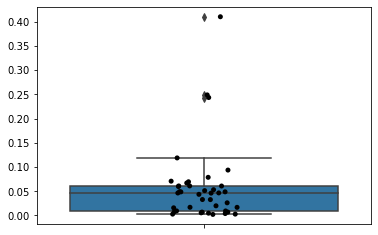

In [311]:
from collections import Counter

GFP_pnew_dict = {}
RFP_pnew_dict = {}

# Two lists: GFP and RFP-active. These lists
GFP_active = [30, 59, 26]
RFP_active = [72,6,29,11,58,59,26]

# Calculate the Pnew for GFP (top strand)
print("GFP....")
for i, parent in enumerate(parent_seq_ids):

    sub_df = df[df['matched_pi'].apply(lambda x: x == parent)]

    scores = sub_df['GFP_mean'].to_list()
    scores = [np.round(n) for n in scores]
    #print(scores)

    # Get the scores counts:
    score_counts = Counter(scores)
    #print(f'{parent}: {score_counts}')

    # Save them as a dictionary (for stacked barplots later)
    sub_dictionary = {}
    sub_dictionary['none'] = score_counts[1]
    sub_dictionary['low'] = score_counts[2]
    sub_dictionary['moderate'] = score_counts[3]
    sub_dictionary['high'] = score_counts[4]

    ID_pnew = (score_counts[2] + score_counts[3] + score_counts[4]) / len(scores)
    GFP_pnew_dict[parent] = ID_pnew

    #print(f'{parent}:{ID_pnew}')
        
print("RFP....")
for i, parent in enumerate(parent_seq_ids):

    sub_df = df[df['matched_pi'].apply(lambda x: x == parent)]

    scores = sub_df['RFP_mean'].to_list()
    scores = [np.round(n) for n in scores]

    # Get the scores counts:
    score_counts = Counter(scores)
    #print(f'{parent}: {score_counts}')

    # Save them as a dictionary (for stacked barplots later)
    sub_dictionary = {}
    sub_dictionary['none'] = score_counts[1]
    sub_dictionary['low'] = score_counts[2]
    sub_dictionary['moderate'] = score_counts[3]
    sub_dictionary['high'] = score_counts[4]

    ID_pnew = (score_counts[2] + score_counts[3] + score_counts[4]) / len(scores)
    RFP_pnew_dict[parent] = ID_pnew
    #print(f'{parent}:{ID_pnew}')
        
pnews = []
for i, parent in enumerate(parent_seq_ids):
    if parent not in GFP_active:
        pnews.append(GFP_pnew_dict[parent])
        
    if parent not in RFP_active:
        pnews.append(RFP_pnew_dict[parent])
        
sns.boxplot(y=pnews)
sns.stripplot(y=pnews, color='black')

plt.savefig('Fig1_D.pdf')

#print(np.median(pnews))

# Fig 2) Mutual information

## A) Calculating mutual information for ALL of the promoter islands (this takes ~1/2 hour to run)
This cell calculates the mutual information for each parent sequence and identifies the hotspots. The output is a dataframe called "hotspot_df" which is also Supplemental data 2. To generate the plots, see Fig S3 and S4.

In [ ]:
import itertools
### Create the hotspot_df
# Define the columns for the dataframe
data = {
    'Hotspot_ID': [],
    'Parent': [],
    'Orientation': [],
    'Coordinate':[]
}
column_names = ['Hotspot_ID', 'Parent', 'Orientation', 'Coordinate']

# Create a DataFrame
hotspot_df = pd.DataFrame(data)

# Get the data to fill the dataframe
fluors = ['GFP','RFP']
blur = 1
window_size = 6

number = 1
for ID in parent_seq_ids:
    print(ID)
    
    for Fluor in fluors:
        print(Fluor)

        # ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
        means, std_devs = calculate_mutual_information(ID, Fluor, blur)
        
        # Get the hotspot indexes
        indexes = index_hotspots(means, std_devs)
        
        # Create a new row for the hotspot_df
        for i in indexes:
            dataframe_row = [number, ID, Fluor, i]
            print(dataframe_row)
            hotspot_df = hotspot_df.append(pd.Series(dataframe_row, index=column_names), ignore_index=True)
            number+=1
            
hotspot_df

In [ ]:
# These lists will be added to the hotspot_df
overlap_10 = []
overlap_35 = []
overlap_none = []

# Go row by row through the hotspot_df and see if there is any overlap
for i, row in hotspot_df.iterrows():
    
    # Define the variables from each row
    ID = int(row['Parent'])
    Fluor = row['Orientation']
    index = int(row['Coordinate'])
    
    # Default value is no overlap
    ten_value = 'no'
    thirtyfive_value = 'no'
    none_value = 'yes'
    
    # Get the PWMs for the parent sequence (it is calculated every iteration, I know it's not efficient...)
    PWM_indexes = WT_pwms(Fluor, window_size, ID)
    minus10s = PWM_indexes['minus10']
    minus35s = PWM_indexes['minus35']
    
    # Surrounding area crops the minus10s list at the index +/- 3 bp
    tens_surrounding = minus10s[index-3:index+3]
    thirtyfives_surrounding = minus35s[index-3:index+3]

    # Is there a motif in this region? Replace the default value if there is    
    if np.sum(tens_surrounding) >= 1:
        ten_value = 'yes'
        none_value = 'no'
        
    if np.sum(thirtyfives_surrounding) >=1:
        thirtyfive_value = 'yes'
        none_value = 'no'
        
    # Append values to lists
    overlap_10.append(ten_value)
    overlap_35.append(thirtyfive_value)
    overlap_none.append(none_value)

# Add these lists to the dataframe
hotspot_df['overlap_10_same'] = overlap_10
hotspot_df['overlap_35_same'] = overlap_35
hotspot_df['overlap_none_same'] = overlap_none

# How many overlap with only -10?
ten_only_count = 0
for i, row in hotspot_df.iterrows():
    if row['overlap_10_same'] == 'yes' and row['overlap_35_same'] == 'no':
        ten_only_count +=1

# How many overlap wtih only -35?
thirtyfive_only_count = 0
for i, row in hotspot_df.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'no':
        thirtyfive_only_count +=1

# How many overlap with both a -10 and a -35?
both_count = 0
for i, row in hotspot_df.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'yes':
        both_count +=1

# How many overlap with neither a -10 nor a -35?
none_count = 0
for i, row in hotspot_df.iterrows():
    if row['overlap_35_same'] == 'no' and row['overlap_10_same'] == 'no':
        none_count +=1

# Plot
# Your total values for each category
total_values = [ten_only_count, thirtyfive_only_count, both_count, none_count]
print(total_values)

In [203]:
hotspot_df.to_csv('Data_S3.csv', index=False)

## B) Promoter Island #59 top strand example

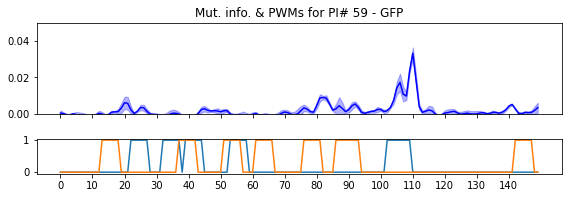

In [312]:
### KWARGS
ID = 59
Fluor = 'GFP'
blur = 1
window_size = 6

import itertools
from scipy.ndimage import gaussian_filter

# Determine whether the lineplot is red or blue
if Fluor == 'RFP':
    farbe = 'red'
elif Fluor == 'GFP':
    farbe = 'blue'
    
# ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
means, std_devs = calculate_mutual_information(ID, Fluor, blur)

# Plot individual...
x_values = range(len(means))

# Create a 2-row, 1-column subplot and select the top box
fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)  # Adjust the figure size as needed
top_ax = axes[0]

# Customize x-axis ticks and annotations (every 10 units)
top_ax.set_xticks(range(0, len(x_values), 10))  # Set ticks every 10 units
top_ax.set_xticklabels(range(0, len(x_values), 10))  # Set tick labels every 10 units

# Create the Seaborn line plot for means in the top subplot
sns.lineplot(x=x_values, y=means, ax=top_ax, color=farbe)

# Shade the region between mean - 1 std_dev and mean + 1 std_dev using Matplotlib
top_ax.fill_between(x_values, [mean - std_dev for mean, std_dev in zip(means, std_devs)], 
                 [mean + std_dev for mean, std_dev in zip(means, std_devs)], alpha=0.3, color=farbe)

top_ax.set_title(f'Mut. info. & PWMs for PI# {ID} - {Fluor}')

# The y-limit
top_ax.set_ylim([0, 1.5*np.max(means)])

# Plot the -10 and -35 boxes
bot_ax = axes[1]
WT_pwms(Fluor,window_size,ID)

# Adjust subplot layout
plt.tight_layout()

# Save
plt.savefig('Fig2_B.pdf')

### Split hotspot_df into two dataframes, corresponding to active vs inactive hotspots

In [86]:
hotspot_df = pd.read_csv("Data_S3.csv")
hotspot_df

,Hotspot_ID,Parent,Orientation,Coordinate,overlap_10_same,overlap_35_same,overlap_none_same
0,1.0,75.0,GFP,61.0,no,no,yes
1,2.0,75.0,GFP,76.0,no,no,yes
2,3.0,75.0,GFP,84.0,no,no,yes
3,4.0,75.0,GFP,108.0,yes,yes,no
4,5.0,75.0,GFP,139.0,no,no,yes
...,...,...,...,...,...,...,...
75,76.0,58.0,RFP,133.0,yes,no,no
76,77.0,30.0,GFP,111.0,no,yes,no
77,78.0,30.0,GFP,131.0,no,no,yes
78,79.0,30.0,GFP,135.0,no,no,yes


In [204]:
active_GFP = [30, 59, 26]
active_RFP = [72, 6, 29, 11, 58]

status_list = []
for i, row in hotspot_df.iterrows():
    
    # If active...
    if int(row['Parent']) in active_GFP and row['Orientation'] == 'GFP' or int(row['Parent']) in active_RFP and row['Orientation'] == 'RFP':
        status = 'active'
    # If inactive...
    else:
        status = 'inactive'
        
    # Append to list
    status_list.append(status)
    
# Add list to dictionary
hotspot_df['status'] = status_list

# Make new dataframes
active_hotspots = hotspot_df[hotspot_df['status'] == 'active'].copy()
inactive_hotspots = hotspot_df[hotspot_df['status'] == 'inactive'].copy()

## C) Hotspot overlap: active hotspots

[5, 8, 6, 10]


Text(0.5, 1.0, 'Hotspot overlap (N=29)')

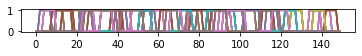

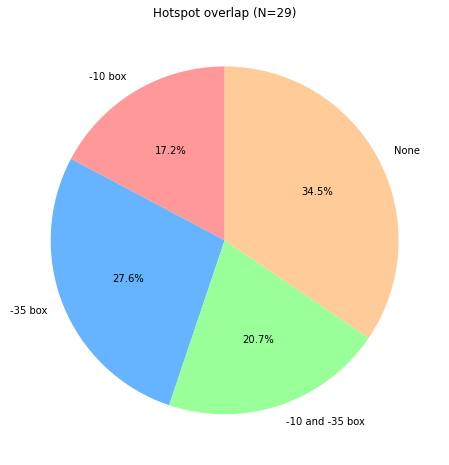

In [207]:
# These lists will be added to the hotspot_df
overlap_10 = []
overlap_35 = []
overlap_none = []

# Go row by row through the hotspot_df and see if there is any overlap
for i, row in active_hotspots.iterrows():
    
    # Define the variables from each row
    ID = int(row['Parent'])
    Fluor = row['Orientation']
    index = int(row['Coordinate'])
    
    # Default value is no overlap
    ten_value = 'no'
    thirtyfive_value = 'no'
    none_value = 'yes'
    
    # Get the PWMs for the parent sequence (it is calculated every iteration, I know it's not efficient...)
    PWM_indexes = WT_pwms(Fluor, window_size, ID)
    minus10s = PWM_indexes['minus10']
    minus35s = PWM_indexes['minus35']
    
    # Surrounding area crops the minus10s list at the index +/- 3 bp
    tens_surrounding = minus10s[index-3:index+3]
    thirtyfives_surrounding = minus35s[index-3:index+3]

    # Is there a motif in this region? Replace the default value if there is    
    if np.sum(tens_surrounding) >= 1:
        ten_value = 'yes'
        none_value = 'no'
        
    if np.sum(thirtyfives_surrounding) >=1:
        thirtyfive_value = 'yes'
        none_value = 'no'
        
    # Append values to lists
    overlap_10.append(ten_value)
    overlap_35.append(thirtyfive_value)
    overlap_none.append(none_value)

# Add these lists to the dataframe
active_hotspots['overlap_10_same'] = overlap_10
active_hotspots['overlap_35_same'] = overlap_35
active_hotspots['overlap_none_same'] = overlap_none

# How many overlap with only -10?
ten_only_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_10_same'] == 'yes' and row['overlap_35_same'] == 'no':
        ten_only_count +=1

# How many overlap wtih only -35?
thirtyfive_only_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'no':
        thirtyfive_only_count +=1

# How many overlap with both a -10 and a -35?
both_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'yes':
        both_count +=1

# How many overlap with neither a -10 nor a -35?
none_count = 0
for i, row in active_hotspots.iterrows():
    if row['overlap_35_same'] == 'no' and row['overlap_10_same'] == 'no':
        none_count +=1

# Plot
# Your total values for each category
total_values = [ten_only_count, thirtyfive_only_count, both_count, none_count]
print(total_values)

# Categories/Labels
categories = ['-10 box', '-35 box', '-10 and -35 box', 'None']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(total_values, labels=categories, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.title(f'Hotspot overlap (N={np.sum(total_values)})')
#plt.savefig('hotspots_active.pdf')

[9, 12, 5, 13]


Text(0.5, 1.0, 'Hotspot overlap (N=39)')

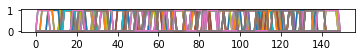

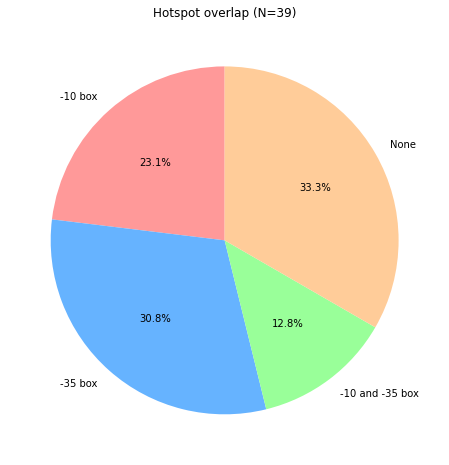

In [209]:
# These lists will be added to the hotspot_df
overlap_10 = []
overlap_35 = []
overlap_none = []

# Go row by row through the hotspot_df and see if there is any overlap
for i, row in inactive_hotspots.iterrows():
    
    # Define the variables from each row
    ID = int(row['Parent'])
    Fluor = row['Orientation']
    index = int(row['Coordinate'])
    
    # Default value is no overlap
    ten_value = 'no'
    thirtyfive_value = 'no'
    none_value = 'yes'
    
    # Get the PWMs for the parent sequence (it is calculated every iteration, I know it's not efficient...)
    PWM_indexes = WT_pwms(Fluor, window_size, ID)
    minus10s = PWM_indexes['minus10']
    minus35s = PWM_indexes['minus35']
    
    # Surrounding area crops the minus10s list at the index +/- 3 bp
    tens_surrounding = minus10s[index-3:index+3]
    thirtyfives_surrounding = minus35s[index-3:index+3]

    # Is there a motif in this region? Replace the default value if there is    
    if np.sum(tens_surrounding) >= 1:
        ten_value = 'yes'
        none_value = 'no'
        
    if np.sum(thirtyfives_surrounding) >=1:
        thirtyfive_value = 'yes'
        none_value = 'no'
        
    # Append values to lists
    overlap_10.append(ten_value)
    overlap_35.append(thirtyfive_value)
    overlap_none.append(none_value)

# Add these lists to the dataframe
inactive_hotspots['overlap_10_same'] = overlap_10
inactive_hotspots['overlap_35_same'] = overlap_35
inactive_hotspots['overlap_none_same'] = overlap_none

# How many overlap with only -10?
ten_only_count = 0
for i, row in inactive_hotspots.iterrows():
    if row['overlap_10_same'] == 'yes' and row['overlap_35_same'] == 'no':
        ten_only_count +=1

# How many overlap wtih only -35?
thirtyfive_only_count = 0
for i, row in inactive_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'no':
        thirtyfive_only_count +=1

# How many overlap with both a -10 and a -35?
both_count = 0
for i, row in inactive_hotspots.iterrows():
    if row['overlap_35_same'] == 'yes' and row['overlap_10_same'] == 'yes':
        both_count +=1

# How many overlap with neither a -10 nor a -35?
none_count = 0
for i, row in inactive_hotspots.iterrows():
    if row['overlap_35_same'] == 'no' and row['overlap_10_same'] == 'no':
        none_count +=1

total_values = [ten_only_count, thirtyfive_only_count, both_count, none_count]
categories = ['-10 box', '-35 box', '-10 and -35 box', 'None']


# Plot
# Your total values for each category
total_values = [ten_only_count, thirtyfive_only_count, both_count, none_count]
print(total_values)

# Categories/Labels
categories = ['-10 box', '-35 box', '-10 and -35 box', 'None']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(total_values, labels=categories, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.title(f'Hotspot overlap (N={np.sum(total_values)})')
#plt.savefig('hotspots_inactive.pdf')

## D) Promoter Island #19 bottom strand example

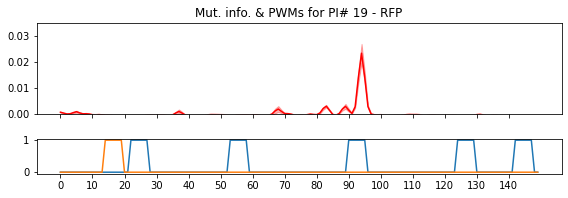

In [313]:
### KWARGS (you can change these for the other promoter islands as you wish)
ID = 19
Fluor = 'RFP'
blur = 1
window_size = 6

import itertools
from scipy.ndimage import gaussian_filter

# Determine whether the lineplot is red or blue
if Fluor == 'RFP':
    farbe = 'red'
elif Fluor == 'GFP':
    farbe = 'blue'
    
# ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
means, std_devs = calculate_mutual_information(ID, Fluor, blur)

# Plot individual...
x_values = range(len(means))

# Create a 2-row, 1-column subplot and select the top box
fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)  # Adjust the figure size as needed
top_ax = axes[0]

# Customize x-axis ticks and annotations (every 10 units)
top_ax.set_xticks(range(0, len(x_values), 10))  # Set ticks every 10 units
top_ax.set_xticklabels(range(0, len(x_values), 10))  # Set tick labels every 10 units

# Create the Seaborn line plot for means in the top subplot
sns.lineplot(x=x_values, y=means, ax=top_ax, color=farbe)

# Shade the region between mean - 1 std_dev and mean + 1 std_dev using Matplotlib
top_ax.fill_between(x_values, [mean - std_dev for mean, std_dev in zip(means, std_devs)], 
                 [mean + std_dev for mean, std_dev in zip(means, std_devs)], alpha=0.3, color=farbe)

top_ax.set_title(f'Mut. info. & PWMs for PI# {ID} - {Fluor}')

# The y-limit
top_ax.set_ylim([0, 1.5*np.max(means)])

# Plot the -10 and -35 boxes
bot_ax = axes[1]
WT_pwms(Fluor,window_size,ID)

# Adjust subplot layout
plt.tight_layout()

# Save
plt.savefig('Fig2_D.pdf')

## E) Promoter Island #11 top strand example

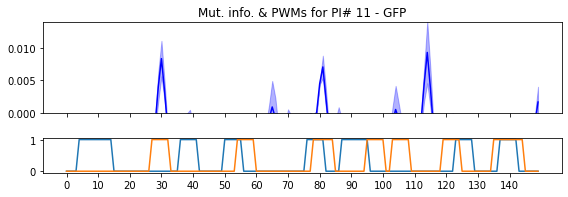

In [314]:
### KWARGS (you can change these for the other promoter islands as you wish)
ID = 11
Fluor = 'GFP'
blur = 1
window_size = 6

import itertools
from scipy.ndimage import gaussian_filter

# Determine whether the lineplot is red or blue
if Fluor == 'RFP':
    farbe = 'red'
elif Fluor == 'GFP':
    farbe = 'blue'
    
# ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
means, std_devs = calculate_mutual_information(ID, Fluor, blur)

# Plot individual...
x_values = range(len(means))

# Create a 2-row, 1-column subplot and select the top box
fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)  # Adjust the figure size as needed
top_ax = axes[0]

# Customize x-axis ticks and annotations (every 10 units)
top_ax.set_xticks(range(0, len(x_values), 10))  # Set ticks every 10 units
top_ax.set_xticklabels(range(0, len(x_values), 10))  # Set tick labels every 10 units

# Create the Seaborn line plot for means in the top subplot
sns.lineplot(x=x_values, y=means, ax=top_ax, color=farbe)

# Shade the region between mean - 1 std_dev and mean + 1 std_dev using Matplotlib
top_ax.fill_between(x_values, [mean - std_dev for mean, std_dev in zip(means, std_devs)], 
                 [mean + std_dev for mean, std_dev in zip(means, std_devs)], alpha=0.3, color=farbe)

top_ax.set_title(f'Mut. info. & PWMs for PI# {ID} - {Fluor}')

# The y-limit
top_ax.set_ylim([0, 1.5*np.max(means)])

# Plot the -10 and -35 boxes
bot_ax = axes[1]
WT_pwms(Fluor,window_size,ID)

# Adjust subplot layout
plt.tight_layout()

# Save
plt.savefig('Fig2_E.pdf')

# Fig 3) Promoters emerge when PIs gain additional -10 and -35 boxes (this takes an entire day to run)

### Analysis for gaining and losing -10 and -35 boxes

In [218]:
### import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import itertools
import numpy as np

### KWARGS: define the following variables:
windows = [6] # size of the sliding window
orientations = ['top','bottom']
fluors = ['GFP','RFP'] # GFP and RFP
TFs = ['minus10','minus35'] # both -10 and -35 boxes
filenames = parent_seq_ids

# Generate all possible combinations of variables from the lists
combinations = itertools.product(orientations, filenames, fluors, TFs, windows)

# Create an empty DataFrame with column names
column_names = ["Orientation", "Parent", "Fluor", "PWM", "Window_size", "P-value", "ROI", "N_without", "N_with", "Fluor_without", "Fluor_with"]
output_df = pd.DataFrame(columns=column_names)

# # Iterate over each combination and call your function with the corresponding inputs
for combination in combinations:
    print(combination)
    
    output = PWM_fluorescence_slide_function(*combination)
    
    if output is None:
        pass
    else:
        
        for n in output: # there can be multiple outputs
            
            # Add the conditions to the row as well
            dataframe_row = list(combination) + n
            
            # Add each row to the dataframe
            row_df = pd.DataFrame([dataframe_row], columns=column_names)
            output_df = pd.concat([output_df, row_df], ignore_index=True)
    
print(output_df)
output_df.to_csv("output_df.csv", index=False)

('top', 75, 'GFP', 'minus10', 6)
('top', 75, 'GFP', 'minus35', 6)
('top', 75, 'RFP', 'minus10', 6)
('top', 75, 'RFP', 'minus35', 6)
('top', 18, 'GFP', 'minus10', 6)
('top', 18, 'GFP', 'minus35', 6)
('top', 18, 'RFP', 'minus10', 6)
('top', 18, 'RFP', 'minus35', 6)
('top', 19, 'GFP', 'minus10', 6)
('top', 19, 'GFP', 'minus35', 6)
('top', 19, 'RFP', 'minus10', 6)
('top', 19, 'RFP', 'minus35', 6)
('top', 3, 'GFP', 'minus10', 6)
('top', 3, 'GFP', 'minus35', 6)
('top', 3, 'RFP', 'minus10', 6)
('top', 3, 'RFP', 'minus35', 6)
('top', 52, 'GFP', 'minus10', 6)
('top', 52, 'GFP', 'minus35', 6)
('top', 52, 'RFP', 'minus10', 6)
('top', 52, 'RFP', 'minus35', 6)
('top', 72, 'GFP', 'minus10', 6)
('top', 72, 'GFP', 'minus35', 6)
('top', 72, 'RFP', 'minus10', 6)
('top', 72, 'RFP', 'minus35', 6)
('top', 25, 'GFP', 'minus10', 6)
('top', 25, 'GFP', 'minus35', 6)
('top', 25, 'RFP', 'minus10', 6)
('top', 25, 'RFP', 'minus35', 6)
('top', 55, 'GFP', 'minus10', 6)
('top', 55, 'GFP', 'minus35', 6)
('top', 55, 'R

In [240]:
output_df = pd.read_csv("output_df.csv")
output_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with
0,top,75,GFP,minus10,6,0.000081,"[7, 13]",62576,241,1.055082,1.021739
1,top,75,GFP,minus10,6,0.989105,"[9, 15]",62552,265,1.054878,1.054795
2,top,75,GFP,minus10,6,0.000032,"[12, 18]",4155,58662,1.048701,1.055556
3,top,75,GFP,minus10,6,0.003092,"[13, 19]",62798,19,1.054945,1.000000
4,top,75,GFP,minus10,6,0.067313,"[17, 23]",62213,604,1.055046,1.046469
...,...,...,...,...,...,...,...,...,...,...,...
5093,bottom,78,RFP,minus35,6,0.112807,"[92, 98]",224,1779,1.000000,1.000000
5094,bottom,78,RFP,minus35,6,0.704114,"[102, 108]",1985,18,1.000000,1.000000
5095,bottom,78,RFP,minus35,6,0.983124,"[105, 111]",99,1904,1.000000,1.000000
5096,bottom,78,RFP,minus35,6,0.458842,"[117, 123]",1993,10,1.000000,1.000000


### Benjamini-Hochberg correction

In [241]:
import statsmodels.stats.multitest as smm

# Perform Benjamini-Hochberg correction
p_values = output_df['P-value'].to_list()

alpha = 0.05
reject, q_values, _, _ = smm.multipletests(p_values, alpha=alpha, method='fdr_bh')
output_df['Q-value'] = q_values
output_df['status'] = reject
output_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,Q-value,status
0,top,75,GFP,minus10,6,0.000081,"[7, 13]",62576,241,1.055082,1.021739,0.000671,True
1,top,75,GFP,minus10,6,0.989105,"[9, 15]",62552,265,1.054878,1.054795,0.994764,False
2,top,75,GFP,minus10,6,0.000032,"[12, 18]",4155,58662,1.048701,1.055556,0.000294,True
3,top,75,GFP,minus10,6,0.003092,"[13, 19]",62798,19,1.054945,1.000000,0.015328,True
4,top,75,GFP,minus10,6,0.067313,"[17, 23]",62213,604,1.055046,1.046469,0.179477,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093,bottom,78,RFP,minus35,6,0.112807,"[92, 98]",224,1779,1.000000,1.000000,0.256509,False
5094,bottom,78,RFP,minus35,6,0.704114,"[102, 108]",1985,18,1.000000,1.000000,0.828595,False
5095,bottom,78,RFP,minus35,6,0.983124,"[105, 111]",99,1904,1.000000,1.000000,0.992445,False
5096,bottom,78,RFP,minus35,6,0.458842,"[117, 123]",1993,10,1.000000,1.000000,0.649230,False


In [242]:
# true_df is a dataframe where only the Q-values are significant
output_df = output_df.drop(output_df[(output_df.status != True)].index)
# Drop rows with 'nan' values
output_df = output_df.dropna()

In [243]:
output_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,Q-value,status
0,top,75,GFP,minus10,6,8.095301e-05,"[7, 13]",62576,241,1.055082,1.021739,6.712821e-04,True
2,top,75,GFP,minus10,6,3.150754e-05,"[12, 18]",4155,58662,1.048701,1.055556,2.941857e-04,True
3,top,75,GFP,minus10,6,3.092358e-03,"[13, 19]",62798,19,1.054945,1.000000,1.532774e-02,True
5,top,75,GFP,minus10,6,2.142800e-03,"[24, 30]",62604,213,1.054795,1.075758,1.129679e-02,True
7,top,75,GFP,minus10,6,5.728217e-61,"[29, 35]",5543,57274,1.028571,1.057692,1.123171e-58,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,bottom,38,GFP,minus35,6,4.635912e-04,"[96, 102]",2174,10,1.019544,1.135435,3.130315e-03,True
5026,bottom,38,RFP,minus35,6,2.289959e-04,"[0, 6]",2174,10,1.000000,1.022874,1.702192e-03,True
5040,bottom,78,GFP,minus10,6,3.388631e-03,"[51, 57]",81,1922,1.033654,1.011391,1.657893e-02,True
5050,bottom,78,GFP,minus35,6,1.236826e-03,"[0, 6]",440,1563,1.022070,1.005435,7.173307e-03,True


### Calculate the change in fluorescence:

In [244]:
# Computer whether the motif was gained or lost and add to the dataframe
gain_loss = []
for i, row in output_df.iterrows():
    
    # number of motifs in each category
    n_without = row['N_without']
    n_with = row['N_with']
    
    if n_with > n_without:
        gain_loss.append('loss')
    elif n_with < n_without:
        gain_loss.append('gain')
output_df['gain-loss'] = gain_loss

In [245]:
# Calculate the median difference in expression:
differences = []
for i, row in output_df.iterrows():
    if row['gain-loss'] == 'gain':
        after = row['Fluor_with']
        before = row['Fluor_without']
    elif row['gain-loss'] == 'loss':
        before = row['Fluor_with']
        after = row['Fluor_without']
    
    difference = after-before
    
    differences.append(difference)
output_df['fluorescence_change'] = differences
output_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,Q-value,status,gain-loss,fluorescence_change
0,top,75,GFP,minus10,6,8.095301e-05,"[7, 13]",62576,241,1.055082,1.021739,6.712821e-04,True,gain,-0.033343
2,top,75,GFP,minus10,6,3.150754e-05,"[12, 18]",4155,58662,1.048701,1.055556,2.941857e-04,True,loss,-0.006854
3,top,75,GFP,minus10,6,3.092358e-03,"[13, 19]",62798,19,1.054945,1.000000,1.532774e-02,True,gain,-0.054945
5,top,75,GFP,minus10,6,2.142800e-03,"[24, 30]",62604,213,1.054795,1.075758,1.129679e-02,True,gain,0.020963
7,top,75,GFP,minus10,6,5.728217e-61,"[29, 35]",5543,57274,1.028571,1.057692,1.123171e-58,True,loss,-0.029121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,bottom,38,GFP,minus35,6,4.635912e-04,"[96, 102]",2174,10,1.019544,1.135435,3.130315e-03,True,gain,0.115891
5026,bottom,38,RFP,minus35,6,2.289959e-04,"[0, 6]",2174,10,1.000000,1.022874,1.702192e-03,True,gain,0.022874
5040,bottom,78,GFP,minus10,6,3.388631e-03,"[51, 57]",81,1922,1.033654,1.011391,1.657893e-02,True,loss,0.022263
5050,bottom,78,GFP,minus35,6,1.236826e-03,"[0, 6]",440,1563,1.022070,1.005435,7.173307e-03,True,loss,0.016635


### Match the changes to hotspots on the same strand

In [246]:
matching_hotspot_IDs = [] # Every row in the output_df will have an entry in this list, either "None" or a "Hotspot_ID" number from the hotspot_df
# For each significant association:
for i, out_row in output_df.iterrows():
    
    hotspot_ID = 'None' # This value is appended to "matching_hotspot_IDs" at the end of the loop, and is updated if a positive match is found.
    opposite = "None"
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    
    # Get the ROI, flip if on the opposite strand, change to a set
    ROI = out_row['ROI']
    ROI_range = eval(ROI)
    if Orientation == 'top' and Fluor == 'GFP' or Orientation == 'bottom' and Fluor == 'RFP':
        opposite = False
    else:
        opposite = True
        ROI_range = [150-n for n in ROI_range]       
    ROI_set = set(ROI_range)

    # Look for a match to a hotspot in the hotspot dataframe:
    for n, row in hotspot_df.iterrows():
        
        Parent = int(row['Parent'])
        Hot_fluor = row['Orientation']
        
        if Hot_fluor == 'GFP':
            Hot_orientation = 'top'
        elif Hot_fluor == 'RFP':
            Hot_orientation = 'bottom'
        
        # Get the index, create a range and set from it
        index = int(row['Coordinate'])
        index_range = range(index-3, index+3)
        index_set = set(index_range)
        
        # Find a match:
        if opposite == False:
            if ID == Parent and Fluor == Hot_fluor and Orientation == Hot_orientation:
            
                #intersection = ROI_set & index_set
                intersection = ROI_set.intersection(index_set)
                if len(intersection) > 0:

                    # Match found. Update the hotspot_ID
                    hotspot_ID = int(row['Hotspot_ID'])
                
        elif opposite == True:
            if ID == Parent and Fluor == Hot_fluor and Orientation != Hot_orientation:
                intersection = ROI_set.intersection(index_set)
                if len(intersection) > 0:
            
                    hotspot_ID = int(row['Hotspot_ID'])           
            
    # Append to the list whether a match was found or not            
    matching_hotspot_IDs.append(hotspot_ID)
            
print(matching_hotspot_IDs[:10])    

['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']


In [247]:
output_df['Hotspot_ID'] = matching_hotspot_IDs
output_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,Q-value,status,gain-loss,fluorescence_change,Hotspot_ID
0,top,75,GFP,minus10,6,8.095301e-05,"[7, 13]",62576,241,1.055082,1.021739,6.712821e-04,True,gain,-0.033343,None
2,top,75,GFP,minus10,6,3.150754e-05,"[12, 18]",4155,58662,1.048701,1.055556,2.941857e-04,True,loss,-0.006854,None
3,top,75,GFP,minus10,6,3.092358e-03,"[13, 19]",62798,19,1.054945,1.000000,1.532774e-02,True,gain,-0.054945,None
5,top,75,GFP,minus10,6,2.142800e-03,"[24, 30]",62604,213,1.054795,1.075758,1.129679e-02,True,gain,0.020963,None
7,top,75,GFP,minus10,6,5.728217e-61,"[29, 35]",5543,57274,1.028571,1.057692,1.123171e-58,True,loss,-0.029121,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,bottom,38,GFP,minus35,6,4.635912e-04,"[96, 102]",2174,10,1.019544,1.135435,3.130315e-03,True,gain,0.115891,None
5026,bottom,38,RFP,minus35,6,2.289959e-04,"[0, 6]",2174,10,1.000000,1.022874,1.702192e-03,True,gain,0.022874,None
5040,bottom,78,GFP,minus10,6,3.388631e-03,"[51, 57]",81,1922,1.033654,1.011391,1.657893e-02,True,loss,0.022263,None
5050,bottom,78,GFP,minus35,6,1.236826e-03,"[0, 6]",440,1563,1.022070,1.005435,7.173307e-03,True,loss,0.016635,None


In [248]:
# Remove values which don't match with a hotspot
output_df = output_df.drop(output_df[(output_df.Hotspot_ID == 'None')].index)
output_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,Q-value,status,gain-loss,fluorescence_change,Hotspot_ID
15,top,75,GFP,minus10,6,3.467199e-09,"[63, 69]",62610,207,1.055249,1.010929,6.546586e-08,True,gain,-0.044320,1
17,top,75,GFP,minus10,6,2.322645e-03,"[78, 84]",62554,263,1.055046,1.030075,1.204704e-02,True,gain,-0.024971,3
18,top,75,GFP,minus10,6,2.453807e-14,"[84, 90]",62008,809,1.055556,1.028571,8.747907e-13,True,gain,-0.026984,3
24,top,75,GFP,minus10,6,4.699806e-14,"[100, 106]",3359,59458,1.037037,1.055556,1.618893e-12,True,loss,-0.018519,4
25,top,75,GFP,minus10,6,2.081119e-08,"[101, 107]",62592,225,1.055224,1.021739,3.596456e-07,True,gain,-0.033485,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4861,bottom,30,GFP,minus10,6,8.889322e-81,"[14, 20]",529,2033,1.295455,2.352201,2.665751e-78,True,loss,-1.056747,68
4862,bottom,30,GFP,minus10,6,1.763171e-08,"[17, 23]",2535,27,2.080000,1.181818,3.099532e-07,True,gain,-0.898182,67
4865,bottom,30,GFP,minus10,6,9.440176e-08,"[32, 38]",2538,24,2.081667,1.188687,1.428072e-06,True,gain,-0.892980,65
4877,bottom,30,GFP,minus35,6,1.342844e-63,"[13, 19]",389,2173,1.272727,2.273810,2.738328e-61,True,loss,-1.001082,68


In [249]:
output_df.to_csv('Data_S4.csv')

## A) Change in fluorescence when creating vs destroying -10 and -35 boxes on the same strand

In [230]:
GFP_active = [30, 59, 26]
RFP_active = [72, 6, 29, 11, 58, 59, 26]

print(GFP_active)
print(RFP_active)

[30, 59, 26]
[72, 6, 29, 11, 58, 59, 26]


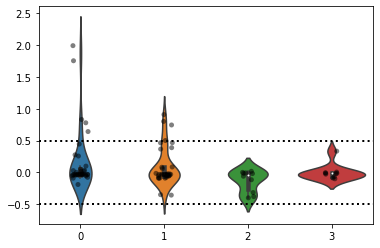

In [232]:
gain_10_same = []
gain_35_same = []
lose_10_same = []
lose_35_same = []

hotspots = []
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Do not look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:
        #print(f'{ID}: {Fluor}')
        pass
    
    else:
        
        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if change >= 0.5:
                hotspots.append(out_row['Hotspot_ID'])
            
            # Gain same strand
            if gain_loss == 'gain':
                if PWM == 'minus10':
                    gain_10_same.append(change)
                elif PWM == 'minus35':
                    gain_35_same.append(change)

            elif gain_loss == 'loss':
                if PWM == 'minus10':
                    lose_10_same.append(change)
                elif PWM == 'minus35':
                    lose_35_same.append(change)
            
# Create a violinplot
all_data = [gain_10_same, gain_35_same, lose_10_same, lose_35_same]
sns.violinplot(data=all_data)
sns.stripplot(data=all_data, color='black', jitter=True, alpha=0.5)
plt.axhline(0.5, linestyle='dotted', color='black', linewidth=2)
plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)
plt.savefig('Fig3_A.pdf')

In [ ]:
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Do not look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:
        #print(f'{ID}: {Fluor}')
        pass
    
    else:
        # only look at the same strand
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if PWM == 'minus35' and change >= 0.5:
                print(out_row)
                print(out_row['Q-value'])
                print()
    
    

In [233]:
gain_10_count = len([n for n in gain_10_same if n >= 0.5])
gain_35_count = len([n for n in gain_35_same if n >= 0.5])
lose_10_count = len([n for n in lose_10_same if n >= 0.5])
lose_35_count = len([n for n in lose_35_same if n >= 0.5])

print(gain_10_count)
print(gain_35_count)
print(lose_10_count)
print(lose_35_count)
print()
gain_10_count = len([n for n in gain_10_same if n <= -0.5])
gain_35_count = len([n for n in gain_35_same if n <= -0.5])
lose_10_count = len([n for n in lose_10_same if n <= -0.5])
lose_35_count = len([n for n in lose_35_same if n <= -0.5])

print(gain_10_count)
print(gain_35_count)
print(lose_10_count)
print(lose_35_count)

5
4
0
0

0
0
0
0


## C) PI#4 gain -10 box

-1.9900827531853418
Orientation                bottom
Parent                          4
Fluor                         RFP
PWM                       minus10
Window_size                     6
P-value                       0.0
ROI                    [126, 132]
N_without                    4163
N_with                         49
Fluor_without            1.086957
Fluor_with               3.077039
Q-value                       0.0
status                       True
gain-loss                    gain
fluorescence_change      1.990083
Hotspot_ID                     47
Name: 4448, dtype: object
7.64073808458046e-32


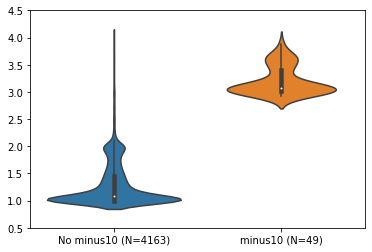

In [234]:
### KWARGS
orientation = 'bottom'
ID = 4
Fluor = 'RFP'
TF = 'minus10'
window = [126,132]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] > 0.5:
        print(row)
        print(row['Q-value'])
        
plt.savefig('Fig3_C.pdf')

## E) PI#1 gain -10 box (No SE)

-1.7529434940547017
Orientation                 top
Parent                        1
Fluor                       GFP
PWM                     minus10
Window_size                   6
P-value                     0.0
ROI                     [9, 15]
N_without                  7541
N_with                      422
Fluor_without          1.138554
Fluor_with             2.891498
Q-value                     0.0
status                     True
gain-loss                  gain
fluorescence_change    1.752943
Hotspot_ID                   31
Name: 1039, dtype: object
2.825317654583983e-173
Orientation                   top
Parent                          1
Fluor                         GFP
PWM                       minus10
Window_size                     6
P-value                  0.000087
ROI                    [136, 142]
N_without                    7950
N_with                         13
Fluor_without            1.151515
Fluor_with               1.981818
Q-value                  0.000714
status     

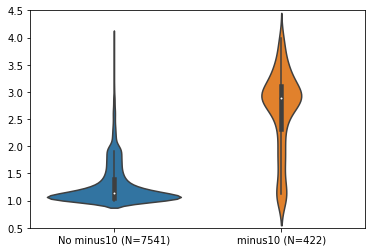

In [236]:
### KWARGS (feel free to change if you want to look at other examples)
orientation = 'top'
ID = 1
Fluor = 'GFP'
TF = 'minus10'
window = [9, 15]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] > 0.5:
        print(row)
        print(row['Q-value'])
        
plt.savefig("Fig3_D.pdf")

## G) PI#55 gain -35 box (Shiko emergence)

-0.7444444444444445
Orientation                bottom
Parent                         75
Fluor                         RFP
PWM                       minus35
Window_size                     6
P-value                       0.0
ROI                    [107, 113]
N_without                   62689
N_with                        128
Fluor_without            1.055556
Fluor_with                    1.8
Q-value                       0.0
status                       True
gain-loss                    gain
fluorescence_change      0.744444
Hotspot_ID                      6
Name: 2757, dtype: object
4.250366963362875e-42


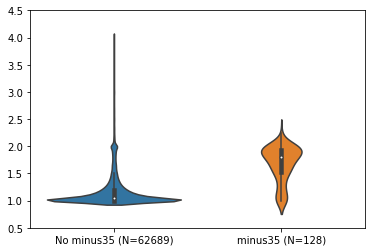

In [237]:
### KWARGS
orientation = 'bottom'
ID = 75
Fluor = 'RFP'
TF = 'minus35'
window = [107, 113]
gain_loss = 'gain'

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] > 0.5:
        print(row)
        print(row['Q-value'])
plt.savefig("Fig3_G.pdf")

# Fig 4) Mapping functional promoters

## A) gaining and losing motifs in already active sequences

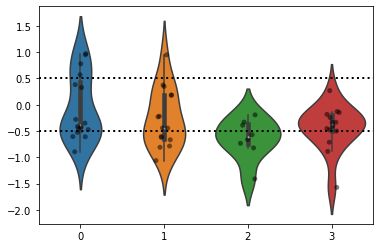

In [251]:
output_df = pd.read_csv('Data_S4.csv')

gain_10_same = []
gain_35_same = []
lose_10_same = []
lose_35_same = []

hotspots = []
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Do not look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:

        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if change >= 0.5:
                hotspots.append(out_row['Hotspot_ID'])
            
            # Gain same strand
            if gain_loss == 'gain':
                if PWM == 'minus10':
                    gain_10_same.append(change)
                elif PWM == 'minus35':
                    gain_35_same.append(change)

            elif gain_loss == 'loss':
                if PWM == 'minus10':
                    lose_10_same.append(change)
                elif PWM == 'minus35':
                    lose_35_same.append(change)
            
# Create a violinplot
all_data = [gain_10_same, gain_35_same, lose_10_same, lose_35_same]
sns.violinplot(data=all_data)
sns.stripplot(data=all_data, color='black', jitter=True, alpha=0.5)
plt.axhline(0.5, linestyle='dotted', color='black', linewidth=2)
plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)
#plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)
plt.savefig('Fig4_A.pdf')

In [54]:
## G) Gain -10 increase example

In [84]:
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Do not look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:

        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if change <= -0.5 and PWM == 'minus10' and ID == 6:
                print(out_row)
                print()

Unnamed: 0                   4044
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus10
Window_size                     6
P-value                   0.00005
ROI                    [119, 125]
N_without                    5878
N_with                         12
Fluor_without            3.208908
Fluor_with               2.603027
Q-value                  0.000436
status                       True
gain-loss                    gain
fluorescence_change     -0.605881
Hotspot_ID                     39
Name: 4044, dtype: object

Unnamed: 0                   4045
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus10
Window_size                     6
P-value                       0.0
ROI                    [134, 140]
N_without                     198
N_with                       5692
Fluor_without            1.814391
Fluor_with           

## C) Gain -35 box PI26

-0.9493333333333336
Unnamed: 0                 2229
Orientation                 top
Parent                       26
Fluor                       GFP
PWM                     minus35
Window_size                   6
P-value                     0.0
ROI                    [21, 27]
N_without                  2762
N_with                       23
Fluor_without          2.666667
Fluor_with                3.616
Q-value                     0.0
status                     True
gain-loss                  gain
fluorescence_change    0.949333
Hotspot_ID                   54
Name: 139, dtype: object
6.297325759112813e-08


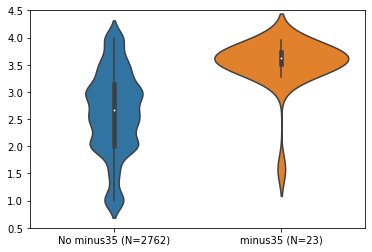

In [315]:
### KWARGS
orientation = 'top'
ID = 26
Fluor = 'GFP'
TF = 'minus35'
window = [21,27]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] > 0.5:
        print(row)
        print(row['Q-value'])
plt.savefig('Fig4_C.pdf')

## D) Gain -10 box PI#26

-0.5700396825396825
Unnamed: 0                 2221
Orientation                 top
Parent                       26
Fluor                       GFP
PWM                     minus10
Window_size                   6
P-value                0.000001
ROI                    [46, 52]
N_without                  2699
N_with                       86
Fluor_without          2.666667
Fluor_with             3.236706
Q-value                0.000011
status                     True
gain-loss                  gain
fluorescence_change     0.57004
Hotspot_ID                   56
Name: 138, dtype: object
1.0809947874013086e-05


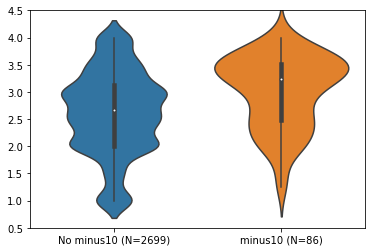

In [316]:
### KWARGS
orientation = 'top'
ID = 26
Fluor = 'GFP'
TF = 'minus10'
window = [46,52]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] > 0.5:
        print(row)
        print(row['Q-value'])
plt.savefig('Fig4_D.pdf')

## F) Destroy -35 box lower fluorescence PI#6

-1.5729274797533037
Unnamed: 0                 4062
Orientation              bottom
Parent                        6
Fluor                       RFP
PWM                     minus35
Window_size                   6
P-value                0.000003
ROI                    [92, 98]
N_without                  5878
N_with                       12
Fluor_without          3.209053
Fluor_with             2.146567
Q-value                0.000033
status                     True
gain-loss                  gain
fluorescence_change   -1.062486
Hotspot_ID                   34
Name: 256, dtype: object
3.346556308202744e-05
Unnamed: 0                   4069
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus35
Window_size                     6
P-value                       0.0
ROI                    [110, 116]
N_without                     152
N_with                       5738
Fluor_without            1.649145
Fluor_with     

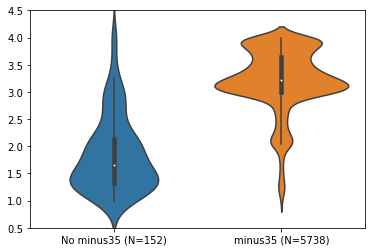

In [317]:
### KWARGS
orientation = 'bottom'
ID = 6
Fluor = 'RFP'
TF = 'minus35'
window = [110, 116]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] < -0.5:
        print(row)
        print(row['Q-value'])
plt.savefig('Fig4_F.pdf')

## G) Destroy -10 box lower fluorescenec PI#6

-1.4114159155242543
Unnamed: 0                   4044
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus10
Window_size                     6
P-value                   0.00005
ROI                    [119, 125]
N_without                    5878
N_with                         12
Fluor_without            3.208908
Fluor_with               2.603027
Q-value                  0.000436
status                       True
gain-loss                    gain
fluorescence_change     -0.605881
Hotspot_ID                     37
Name: 253, dtype: object
0.0004359056402968
Unnamed: 0                   4045
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus10
Window_size                     6
P-value                       0.0
ROI                    [134, 140]
N_without                     198
N_with                       5692
Fluor_without     

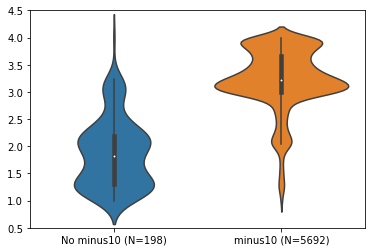

In [318]:
### KWARGS
orientation = 'bottom'
ID = 6
Fluor = 'RFP'
TF = 'minus10'
window = [134, 140]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] < -0.5:
        print(row)
        print(row['Q-value'])
plt.savefig('Fig4_G.pdf')

# Fig 5) Gaining boxes lowers expression

## B) Gain -35 or -10 box lower fluorescence PI#6

1.0624857662903247
Unnamed: 0                 4062
Orientation              bottom
Parent                        6
Fluor                       RFP
PWM                     minus35
Window_size                   6
P-value                0.000003
ROI                    [92, 98]
N_without                  5878
N_with                       12
Fluor_without          3.209053
Fluor_with             2.146567
Q-value                0.000033
status                     True
gain-loss                  gain
fluorescence_change   -1.062486
Hotspot_ID                   34
Name: 256, dtype: object
3.346556308202744e-05
Unnamed: 0                   4069
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus35
Window_size                     6
P-value                       0.0
ROI                    [110, 116]
N_without                     152
N_with                       5738
Fluor_without            1.649145
Fluor_with      

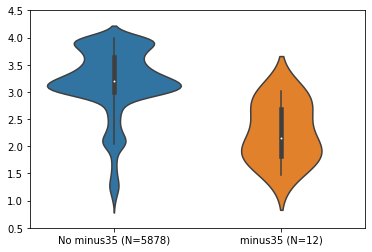

In [320]:
### KWARGS
orientation = 'bottom'
ID = 6
Fluor = 'RFP'
TF = 'minus35'
window = [92, 98]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] < -0.5:
        print(row)
        print(row['Q-value'])
plt.savefig('Fig5_B_35.pdf')

0.6058807134069619
Unnamed: 0                   4044
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus10
Window_size                     6
P-value                   0.00005
ROI                    [119, 125]
N_without                    5878
N_with                         12
Fluor_without            3.208908
Fluor_with               2.603027
Q-value                  0.000436
status                       True
gain-loss                    gain
fluorescence_change     -0.605881
Hotspot_ID                     37
Name: 253, dtype: object
0.0004359056402968
Unnamed: 0                   4045
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus10
Window_size                     6
P-value                       0.0
ROI                    [134, 140]
N_without                     198
N_with                       5692
Fluor_without      

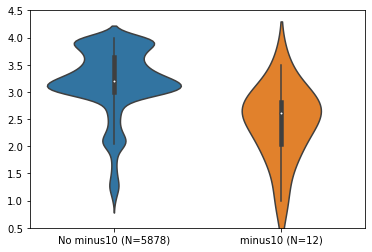

In [321]:
### KWARGS
orientation = 'bottom'
ID = 6
Fluor = 'RFP'
TF = 'minus10'
window = [119, 125]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] < -0.5:
        print(row)
        print(row['Q-value'])
plt.savefig('Fig5_B_10.pdf')

## E) Gaining destroys preexisting promoter architecture

0.7859320761797539
Unnamed: 0                 3398
Orientation              bottom
Parent                       72
Fluor                       RFP
PWM                     minus35
Window_size                   6
P-value                     0.0
ROI                    [73, 79]
N_without                 11107
N_with                       36
Fluor_without          1.818182
Fluor_with              1.03225
Q-value                     0.0
status                     True
gain-loss                  gain
fluorescence_change   -0.785932
Hotspot_ID                   24
Name: 228, dtype: object
1.2486454467921686e-07
Unnamed: 0                  3405
Orientation               bottom
Parent                        72
Fluor                        RFP
PWM                      minus35
Window_size                    6
P-value                      0.0
ROI                    [97, 103]
N_without                  11099
N_with                        44
Fluor_without           1.818182
Fluor_with              1.

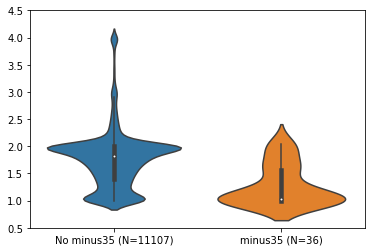

In [325]:
### KWARGS
orientation = 'bottom'
ID = 72
Fluor = 'RFP'
TF = 'minus35'
window = [73, 79]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] < -0.5:
        print(row)
        print(row['Q-value'])
plt.savefig('Fig5_E_35_1.pdf')

0.8096450556127972
Unnamed: 0                 3398
Orientation              bottom
Parent                       72
Fluor                       RFP
PWM                     minus35
Window_size                   6
P-value                     0.0
ROI                    [73, 79]
N_without                 11107
N_with                       36
Fluor_without          1.818182
Fluor_with              1.03225
Q-value                     0.0
status                     True
gain-loss                  gain
fluorescence_change   -0.785932
Hotspot_ID                   24
Name: 228, dtype: object
1.2486454467921686e-07
Unnamed: 0                  3405
Orientation               bottom
Parent                        72
Fluor                        RFP
PWM                      minus35
Window_size                    6
P-value                      0.0
ROI                    [97, 103]
N_without                  11099
N_with                        44
Fluor_without           1.818182
Fluor_with              1.

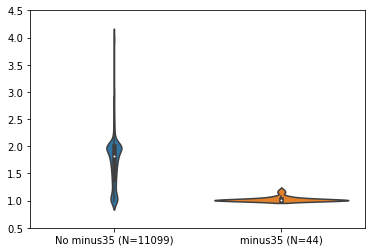

In [324]:
### KWARGS
orientation = 'bottom'
ID = 72
Fluor = 'RFP'
TF = 'minus35'
window = [97, 103]

individual_gain_loss_pwm(orientation, ID, Fluor, TF, window)

# Look for it first...
for i, row in output_df.iterrows():
    if row['Parent'] == ID and row['Orientation'] == orientation and row['Fluor'] == Fluor and row['PWM'] == TF and row['fluorescence_change'] < -0.5:
        print(row)
        print(row['Q-value'])
plt.savefig('Fig5_E_35_2.pdf')

### Increasing affinity analysis:

In [167]:
### import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import itertools
import numpy as np

# KWARGS
orientations = ['top','bottom']
TFs = ['minus10','minus35']
windows = [6]
fluors = ['GFP', 'RFP']

# Generate all possible combinations of variables from the lists
combinations = itertools.product(parent_seq_ids, fluors, orientations, TFs, windows)

# Create an empty DataFrame with column names
column_names = ["Orientation", "Parent", "Fluor", "PWM", "Window_size", "P-value", "ROI", "N_without", "N_with", "Fluor_without", "Fluor_with"]
increase_df = pd.DataFrame(columns=column_names)

# # Iterate over each combination and call your function with the corresponding inputs
for combination in combinations:
    print(combination)
    
    output = increase_PWM(*combination)
    
    if output is None:
        pass
    else:
        
        for n in output: # there can be multiple outputs
            
            # Add each row to the dataframe
            row_df = pd.DataFrame([n], columns=column_names)            
            increase_df = pd.concat([increase_df, row_df], ignore_index=True)
    
print(increase_df)

(75, 'GFP', 'top', 'minus10', 6)
window_list: [[12, 18], [29, 35], [100, 106], [103, 109], [120, 126]]
wt_scores: [6.0907574, 6.5031385, 7.394471, 6.0907574, 7.393245]
(75, 'GFP', 'top', 'minus35', 6)
window_list: [[23, 29], [24, 30], [43, 49], [110, 116], [130, 136]]
wt_scores: [4.0117197, 4.3838296, 4.0605984, 7.485109, 3.8192265]
(75, 'GFP', 'bottom', 'minus10', 6)
window_list: [[12, 18], [29, 35], [100, 106], [103, 109], [120, 126]]
wt_scores: [6.0907574, 6.5031385, 7.394471, 6.0907574, 7.393245]
(75, 'GFP', 'bottom', 'minus35', 6)
window_list: [[23, 29], [24, 30], [43, 49], [110, 116], [130, 136]]
wt_scores: [4.0117197, 4.3838296, 4.0605984, 7.485109, 3.8192265]
(75, 'RFP', 'top', 'minus10', 6)
window_list: [[97, 103], [131, 137]]
wt_scores: [4.9296484, 8.546933]
(75, 'RFP', 'top', 'minus35', 6)
window_list: [[13, 19], [67, 73], [82, 88], [87, 93], [120, 126]]
wt_scores: [7.485109, 4.5858684, 6.2028923, 5.413032, 3.3902879]
(75, 'RFP', 'bottom', 'minus10', 6)
window_list: [[97, 10

In [168]:
increase_df.to_csv("affinity_changes.csv")

### Calculate the change in fluorescence:
This analysis used a two-tailed MWU test, and looked for significant differences in fluorescence. This means that the increase_df currently includes significant values where increasing a PWM lowers and raises fluorescence. We take the difference to find out if fluorescence was gained or lost.

In [169]:
# Calculate the fluorescence changes between each event
fluorescence_changes = []
for i, row in increase_df.iterrows():
    difference = row['Fluor_with'] - row['Fluor_without']
    fluorescence_changes.append(difference)
    
# Append to the increase_df
increase_df['fluorescence_change'] = fluorescence_changes

### Benjamini-Hochberg correction

In [170]:
import statsmodels.stats.multitest as smm

# Perform Benjamini-Hochberg correction
p_values = increase_df['P-value'].to_list()

alpha = 0.05
reject, q_values, _, _ = smm.multipletests(p_values, alpha=alpha, method='fdr_bh')
increase_df['Q-value'] = q_values
increase_df['status'] = reject
    
# Sort the DataFrame by the 'Score' column in descending order
increase_df = increase_df.sort_values(by='fluorescence_change', ascending=False)
increase_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,fluorescence_change,Q-value,status
444,bottom,59,GFP,minus10,6,3.284322e-51,"[39, 45]",3358,98,1.536293,3.936763,2.400470,3.092736e-49,True
103,top,52,GFP,minus35,6,6.837823e-55,"[98, 104]",15524,135,1.023256,3.172414,2.149158,7.726740e-53,True
146,bottom,72,RFP,minus35,6,2.048138e-105,"[74, 80]",10951,192,1.805556,3.944939,2.139383,3.857326e-103,True
204,top,1,GFP,minus10,6,1.218830e-95,"[143, 149]",7776,187,1.144533,2.494737,1.350203,1.721598e-93,True
436,top,59,GFP,minus10,6,1.252882e-29,"[102, 108]",3347,109,1.536842,2.767068,1.230226,7.078784e-28,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,bottom,29,RFP,minus10,6,6.495441e-25,"[113, 119]",5198,127,1.647059,1.028169,-0.618890,3.058270e-23,True
449,bottom,59,RFP,minus10,6,6.370461e-07,"[116, 122]",3430,26,1.647854,1.023810,-0.624044,7.658108e-06,True
141,bottom,72,RFP,minus10,6,1.005880e-42,"[94, 100]",11033,110,1.821429,1.019797,-0.801632,7.104027e-41,True
503,bottom,30,GFP,minus10,6,9.883452e-08,"[32, 38]",2539,23,2.080000,1.187500,-0.892500,1.745047e-06,True


In [171]:
# true_df is a dataframe where only the Q-values are significant
increase_df = increase_df.drop(increase_df[(increase_df.status != True)].index)
increase_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,fluorescence_change,Q-value,status
444,bottom,59,GFP,minus10,6,3.284322e-51,"[39, 45]",3358,98,1.536293,3.936763,2.400470,3.092736e-49,True
103,top,52,GFP,minus35,6,6.837823e-55,"[98, 104]",15524,135,1.023256,3.172414,2.149158,7.726740e-53,True
146,bottom,72,RFP,minus35,6,2.048138e-105,"[74, 80]",10951,192,1.805556,3.944939,2.139383,3.857326e-103,True
204,top,1,GFP,minus10,6,1.218830e-95,"[143, 149]",7776,187,1.144533,2.494737,1.350203,1.721598e-93,True
436,top,59,GFP,minus10,6,1.252882e-29,"[102, 108]",3347,109,1.536842,2.767068,1.230226,7.078784e-28,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,bottom,29,RFP,minus10,6,6.495441e-25,"[113, 119]",5198,127,1.647059,1.028169,-0.618890,3.058270e-23,True
449,bottom,59,RFP,minus10,6,6.370461e-07,"[116, 122]",3430,26,1.647854,1.023810,-0.624044,7.658108e-06,True
141,bottom,72,RFP,minus10,6,1.005880e-42,"[94, 100]",11033,110,1.821429,1.019797,-0.801632,7.104027e-41,True
503,bottom,30,GFP,minus10,6,9.883452e-08,"[32, 38]",2539,23,2.080000,1.187500,-0.892500,1.745047e-06,True


### Map each change to a hotspot_ID:

In [174]:
matching_hotspot_IDs = [] # Every row in the output_df will have an entry in this list, either "None" or a "Hotspot_ID" number from the hotspot_df
# For each significant association:
for i, out_row in increase_df.iterrows():
    
    hotspot_ID = 'None' # This value is appended to "matching_hotspot_IDs" at the end of the loop, and is updated if a positive match is found.
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    
    # Get the ROI, flip if on the opposite strand, change to a set
    ROI = out_row['ROI']
    #ROI_range = eval(ROI)
    if Orientation == 'top' and Fluor == 'GFP' or Orientation == 'bottom' and Fluor == 'RFP':
        pass
    else:
        ROI_range = [150-n for n in ROI_range]       
    ROI_set = set(ROI_range)

    # Look for a match to a hotspot in the hotspot dataframe:
    for n, row in hotspot_df.iterrows():
        
        Parent = int(row['Parent'])
        Hot_fluor = row['Orientation']
        
        if Hot_fluor == 'GFP':
            Hot_orientation = 'top'
        elif Hot_fluor == 'RFP':
            Hot_orientation = 'bottom'
        
        # Get the index, create a range and set from it
        index = int(row['Coordinate'])
        index_range = range(index-3, index+3)
        index_set = set(index_range)
        
        # Find a match:
        if ID == Parent and Fluor == Hot_fluor and Orientation == Hot_orientation:
            
            #intersection = ROI_set & index_set
            intersection = ROI_set.intersection(index_set)
            if len(intersection) > 0:
            
                # Match found. Update the hotspot_ID
                hotspot_ID = int(row['Hotspot_ID'])
                
    # Append to the list whether a match was found or not            
    matching_hotspot_IDs.append(hotspot_ID)
            
print(matching_hotspot_IDs[:10])    

['None', 'None', 'None', 'None', 90, 'None', 'None', 29, 'None', 'None']


In [177]:
print(matching_hotspot_IDs)
increase_df['Hotspot_ID'] = matching_hotspot_IDs

['None', 'None', 'None', 'None', 90, 'None', 'None', 29, 'None', 'None', 'None', 'None', 'None', 'None', 'None', 39, 111, 3, 'None', 'None', 'None', 'None', 'None', 'None', 93, 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 15, 'None', 'None', 1, 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 39, 39, 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 56, 56, 56, 77, 'None', 'None', 'None', 'None', 'None', 44, 44, 'None', 1, 'None', 1, 'None', 'None', 'None', 'None', 44, 44, 44, 'None', 44, 44, 'None', 15, 35, 'None', 3, 3, 3, 'None', 'None', 20, 'None', 'None', 1, 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 93, 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 111, 'None', 'None', 'None

In [178]:
# Remove values which don't match with a hotspot
increase_df = increase_df.drop(increase_df[(increase_df.Hotspot_ID == 'None')].index)
increase_df

,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,fluorescence_change,Q-value,status,Hotspot_ID
436,top,59,GFP,minus10,6,1.252882e-29,"[102, 108]",3347,109,1.536842,2.767068,1.230226,7.078784e-28,True,90
61,bottom,19,RFP,minus10,6,1.365225e-227,"[90, 96]",19666,316,1.000000,1.824808,0.824808,7.713519e-225,True,29
112,bottom,52,RFP,minus10,6,7.035820e-06,"[109, 115]",15647,12,1.000000,1.498093,0.498093,5.999272e-05,True,39
472,bottom,26,RFP,minus35,6,2.231893e-03,"[108, 114]",2769,16,3.464286,3.911147,0.446861,1.178523e-02,True,111
4,top,75,GFP,minus10,6,2.448843e-20,"[120, 126]",62630,187,1.054545,1.461538,0.406993,9.882832e-19,True,3
452,bottom,59,RFP,minus35,6,6.612245e-05,"[53, 59]",3282,174,1.627386,1.878676,0.251290,4.981225e-04,True,93
20,top,18,GFP,minus35,6,2.173942e-18,"[56, 62]",29249,385,1.037037,1.107143,0.070106,8.188513e-17,True,15
8,top,75,GFP,minus35,6,4.221603e-05,"[110, 116]",62521,296,1.054545,1.106686,0.052140,3.359444e-04,True,1
111,bottom,52,RFP,minus10,6,1.008513e-02,"[82, 88]",15481,178,1.000000,1.000000,0.000000,4.099350e-02,True,39
113,bottom,52,RFP,minus10,6,4.390965e-03,"[125, 131]",15494,165,1.000000,1.000000,0.000000,2.050327e-02,True,39


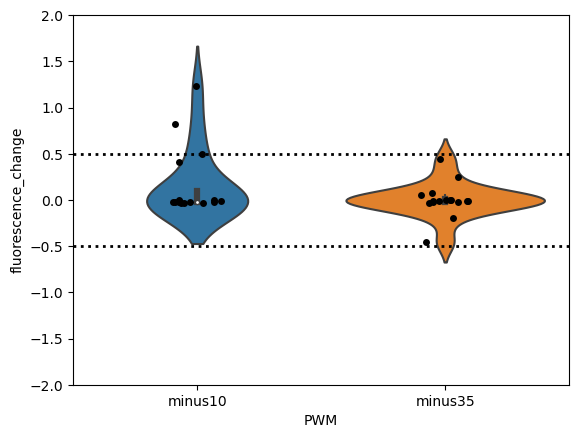

In [188]:
sns.violinplot(data=increase_df, x='PWM', y='fluorescence_change')
sns.stripplot(data=increase_df, x='PWM', y='fluorescence_change', color='black', jitter=True)
plt.axhline(0.5, linestyle='dotted', color='black', linewidth=2)
plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)
plt.ylim(-2, 2)
plt.savefig('affinity_increases.pdf')

In [125]:
output_df

,Unnamed: 0,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,Q-value,status,gain-loss,fluorescence_change,Hotspot_ID
15,15,top,75,GFP,minus10,6,3.467199e-09,"[63, 69]",62610,207,1.055249,1.010929,6.546586e-08,True,gain,-0.044320,1
17,17,top,75,GFP,minus10,6,2.322645e-03,"[78, 84]",62554,263,1.055046,1.030075,1.204704e-02,True,gain,-0.024971,3
18,18,top,75,GFP,minus10,6,2.453807e-14,"[84, 90]",62008,809,1.055556,1.028571,8.747907e-13,True,gain,-0.026984,3
24,24,top,75,GFP,minus10,6,4.699806e-14,"[100, 106]",3359,59458,1.037037,1.055556,1.618893e-12,True,loss,-0.018519,4
25,25,top,75,GFP,minus10,6,2.081119e-08,"[101, 107]",62592,225,1.055224,1.021739,3.596456e-07,True,gain,-0.033485,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4832,4832,bottom,58,RFP,minus10,6,1.301659e-03,"[50, 56]",193,2409,1.980769,1.940678,7.489679e-03,True,loss,0.040091,120
4841,4841,bottom,58,RFP,minus10,6,3.002659e-19,"[128, 134]",163,2439,1.246291,1.950000,1.471880e-17,True,loss,-0.703709,124
4842,4842,bottom,58,RFP,minus10,6,4.055269e-33,"[131, 137]",126,2476,1.133399,1.952381,3.691743e-31,True,loss,-0.818982,124
4850,4850,bottom,58,RFP,minus35,6,9.316606e-03,"[53, 59]",2590,12,1.943127,2.000000,3.861489e-02,True,gain,0.056873,120


C:\Users\timot\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


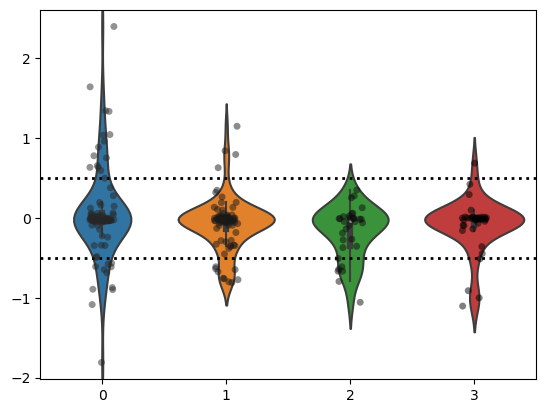

In [144]:
gain_10_opp = []
gain_35_opp = []
lose_10_opp = []
lose_35_opp = []

for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
        pass
    else:
        
        # Gain same strand
        if gain_loss == 'gain':
            if PWM == 'minus10':
                gain_10_opp.append(change)
            elif PWM == 'minus35':
                gain_35_opp.append(change)

        elif gain_loss == 'loss' :
            if PWM == 'minus10':
                lose_10_opp.append(change)
            elif PWM == 'minus35':
                lose_35_opp.append(change)
            
# Create a violinplot
all_data = [gain_10_opp, gain_35_opp, lose_10_opp, lose_35_opp]
sns.violinplot(data=all_data)
sns.stripplot(data=all_data, color='black', jitter=True, alpha=0.5)
plt.axhline(0.5, linestyle='dotted', color='black', linewidth=2)
plt.axhline(-0.5, linestyle='dotted', color='black', linewidth=2)

In [ ]:
# Get a list of hotspots where the gain is associated with the opposite strand

### Are any of these mutually exclusive? Just one example: Gaining a -10 box on top strand decreases fluorescence by -0.57 a.u. on the bottom strand.

In [156]:
### Create a list of hotspots where gaining a -10 box on the opposite strand increases fluorescence
opposite_hotspots = [] # A list of hotspot IDs where gaining a motif on the opposite strand is associated with increasing fluorescence.
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = np.abs(out_row['fluorescence_change'])
    
    if Fluor == 'GFP' and Orientation == 'bottom' or Fluor == 'RFP' and Orientation == 'top':
        if change >= 0.5:
            opposite_hotspots.append(out_row['Hotspot_ID'])
            
print(opposite_hotspots)

### Loop through these hotspots and see how many other associations are found for the hotspot.
for hotspot in opposite_hotspots:
    
    associations = []
    
    for i, out_row in output_df.iterrows():
        if out_row['Hotspot_ID'] == hotspot:
            associations.append(out_row)
            
    #print(f'hotspot: {hotspot} is associated with {len(associations)} additional gains or losses.')
    if len(associations) == 1:
        print(hotspot)
        
### Which one was this?
for i, out_row in output_df.iterrows():
    if out_row['Hotspot_ID'] == 104:
        print(out_row)
        print()

[6, 7, 19, 28, 50, 50, 50, 50, 50, 50, 59, 59, 66, 66, 66, 66, 66, 65, 63, 66, 64, 75, 75, 75, 73, 75, 73, 105, 104, 97, 97, 96, 96, 113, 113, 124, 124, 69, 79, 92, 108, 110, 109, 108, 107, 118, 118, 117, 115, 118]
104
Unnamed: 0                 2073
Orientation                 top
Parent                       11
Fluor                       RFP
PWM                     minus10
Window_size                   6
P-value                 0.00708
ROI                    [22, 28]
N_without                  3664
N_with                       12
Fluor_without          1.628986
Fluor_with             1.063588
Q-value                0.030875
status                     True
gain-loss                  gain
fluorescence_change   -0.565398
Hotspot_ID                  104
Name: 2073, dtype: object



In [159]:
output_df

,Unnamed: 0,Orientation,Parent,Fluor,PWM,Window_size,P-value,ROI,N_without,N_with,Fluor_without,Fluor_with,Q-value,status,gain-loss,fluorescence_change,Hotspot_ID
15,15,top,75,GFP,minus10,6,3.467199e-09,"[63, 69]",62610,207,1.055249,1.010929,6.546586e-08,True,gain,-0.044320,1
17,17,top,75,GFP,minus10,6,2.322645e-03,"[78, 84]",62554,263,1.055046,1.030075,1.204704e-02,True,gain,-0.024971,3
18,18,top,75,GFP,minus10,6,2.453807e-14,"[84, 90]",62008,809,1.055556,1.028571,8.747907e-13,True,gain,-0.026984,3
24,24,top,75,GFP,minus10,6,4.699806e-14,"[100, 106]",3359,59458,1.037037,1.055556,1.618893e-12,True,loss,-0.018519,4
25,25,top,75,GFP,minus10,6,2.081119e-08,"[101, 107]",62592,225,1.055224,1.021739,3.596456e-07,True,gain,-0.033485,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4861,4861,bottom,30,GFP,minus10,6,8.889322e-81,"[14, 20]",529,2033,1.295455,2.352201,2.665751e-78,True,loss,-1.056747,118
4862,4862,bottom,30,GFP,minus10,6,1.763171e-08,"[17, 23]",2535,27,2.080000,1.181818,3.099532e-07,True,gain,-0.898182,117
4865,4865,bottom,30,GFP,minus10,6,9.440176e-08,"[32, 38]",2538,24,2.081667,1.188687,1.428072e-06,True,gain,-0.892980,115
4877,4877,bottom,30,GFP,minus35,6,1.342844e-63,"[13, 19]",389,2173,1.272727,2.273810,2.738328e-61,True,loss,-1.001082,118


### I once identified examples of Webster emergence. Why are these no longer in my dataset?

### PI#30 loses -10 on bottom strand and decreases GFP expression

In [164]:
for i, out_row in output_df.iterrows():
    if out_row['Parent'] == 30 and out_row['Fluor'] == 'GFP' and out_row['PWM'] == 'minus10' and out_row['Orientation'] == 'top':
        print(out_row)
        print()

Unnamed: 0                   2355
Orientation                   top
Parent                         30
Fluor                         GFP
PWM                       minus10
Window_size                     6
P-value                       0.0
ROI                    [111, 117]
N_without                    2537
N_with                         25
Fluor_without            2.083333
Fluor_with                 1.1875
Q-value                  0.000001
status                       True
gain-loss                    gain
fluorescence_change     -0.895833
Hotspot_ID                    115
Name: 2355, dtype: object

Unnamed: 0                   2359
Orientation                   top
Parent                         30
Fluor                         GFP
PWM                       minus10
Window_size                     6
P-value                  0.001002
ROI                    [129, 135]
N_without                    2477
N_with                         85
Fluor_without                2.08
Fluor_with           

# DataS1 (creating the sort-seq dataframe) 
(Input = 'filter_insert.csv', output = 'trimmed_df.csv', feel free to skip this step and just load 'trimmed_df.csv')

### Import the dataframe

In [276]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('Data_S2.csv')
df

,seq,sum_alpha,sum_beta,sum_gamma,sum_bin1,sum_bin2,sum_bin3,sum_bin4,sum_bin5,sum_bin6,...,sum_occur,matched_pi,distance,GFP_mean,GFP_std,GFP_median,RFP_mean,RFP_std,RFP_median,daughter_count
0,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,14,28,9,36,0,0,0,15,0,...,51,19,3,1.000000,0.000000,1.0,1.000000,0.000000,1.0,20061
1,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,34,72,29,88,0,0,1,46,0,...,135,19,4,1.033708,0.316208,1.0,1.000000,0.000000,1.0,20061
2,AAAAAATAATTACTTGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,12,29,5,32,0,0,0,14,0,...,46,19,2,1.000000,0.000000,1.0,1.000000,0.000000,1.0,20061
3,AAAAAATAATTTCATGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,8,24,5,22,0,0,0,15,0,...,37,19,3,1.000000,0.000000,1.0,1.000000,0.000000,1.0,20061
4,AAAAAATAATTTCTCGCGTTATTTTCGGCACCTTTTATGTAGCGAA...,33,14,9,27,0,0,0,29,0,...,56,19,2,1.000000,0.000000,1.0,1.000000,0.000000,1.0,20061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245634,TTTTTGTGTTGTTATATTTTTTATCTTGTACTTTTTTTTCGGGTAC...,8,8,24,6,0,0,0,34,0,...,40,64,3,1.000000,0.000000,1.0,1.000000,0.000000,1.0,5931
245635,TTTTTTATACATTGTATTTAGATGTGATTTAGTTTGTCAATTAATT...,33,12,19,1,0,0,0,0,0,...,64,6,2,1.000000,0.000000,1.0,3.079365,0.270308,3.0,8920
245636,TTTTTTATACATTGTATTTAGATGTGATTTAGTTTGTCAATTAATT...,222,192,183,6,0,0,0,0,1,...,597,6,4,1.000000,0.000000,1.0,3.072758,0.266174,3.0,8920
245637,TTTTTTATACATTGTATTTAGATGTGATTTAGTTTGTCAATTAATT...,290,491,535,157,0,0,1,1,6,...,1316,6,1,1.018987,0.237911,1.0,3.037997,0.228247,3.0,8920


### Remove the following...

In [ ]:
# remove sequences not equal to 150 bp
df = df[df['seq'].apply(lambda x: len(x) == 150)]

# A read must occur more than 30 times between each of the bins
df = df[df['sum_occur'].apply(lambda x: x >= 30)]

# the number of mutations less than 10
df = df[df['distance'].apply(lambda x: x <= 10)]

### Calculate fluorescence scores for RFP and GFP

In [ ]:
# Calculate the fluorescence scores
GFP_mean = []
GFP_std = []
RFP_mean = []
RFP_std = []

GFP_median = []
RFP_median = []

for i, row in df.iterrows():
    
    ### GFP
    # number of 1s, 2s, 3s, and 4s for GFP
    one_list = [1] * row['sum_bin1']
    two_list = [2] * row['sum_bin2']
    three_list = [3] * row['sum_bin3']
    four_list = [4] * row['sum_bin4']
    
    # Add scores together into a list
    GFP_list = one_list + two_list + three_list + four_list
    
    # Append mean and std to list
    GFP_mean.append(np.mean(GFP_list))
    GFP_std.append(np.std(GFP_list))
    GFP_median.append(np.median(GFP_list))
    
    ### RFP
    # number of 1s, 2s, 3s, and 4s for GFP
    one_list = [1] * row['sum_bin5']
    two_list = [2] * row['sum_bin6']
    three_list = [3] * row['sum_bin7']
    four_list = [4] * row['sum_bin8']
    
    # Add scores together into a list
    RFP_list = one_list + two_list + three_list + four_list
    
    # Append mean and std to list
    RFP_mean.append(np.mean(RFP_list))
    RFP_std.append(np.std(RFP_list))
    RFP_median.append(np.median(RFP_list))
    
# Append to the dataframe
df['GFP_mean'] = GFP_mean
df['GFP_std'] = GFP_std
df['GFP_median'] = GFP_median

df['RFP_mean'] = RFP_mean
df['RFP_std'] = RFP_std
df['RFP_median'] = RFP_median

df

# Fig S1) Scrambling the promoter island sequences and AT-content

## A) map of -10 and -35 boxes

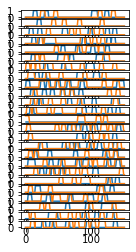

In [277]:
for index, parent_seq_id in enumerate(parent_seq_ids):   
    plt.subplot(len(parent_seq_ids), 1, index+1)
    WT_pwms('GFP',6,parent_seq_id)
    
plt.savefig("FigS1_A_top.pdf", dpi=300)

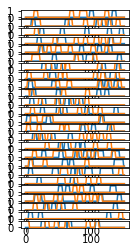

In [278]:
for index, parent_seq_id in enumerate(parent_seq_ids):   
    plt.subplot(len(parent_seq_ids), 1, index+1)
    WT_pwms('RFP',6,parent_seq_id)
    
plt.savefig('FigS1_A_bottom.pdf')

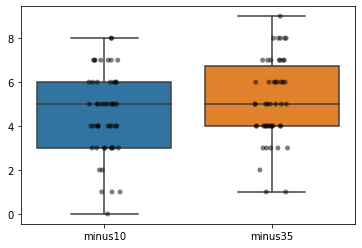

In [283]:
# This dictionary will hold the output from peaks_list for each of these four_boxplots
boxplots_dict = {}

# Loop through each to make the final plot:
for TF in list_of_TFs:
    
    # Unique values for each iteration
    peaks_list = []
    
    # Get the number of motifs on the top and bottom
    for index, parent_seq_id in enumerate(parent_seq_ids):

        # Get the plots for the number of motifs on the top strand
        arr = count_motifs('top', TF, 6, parent_seq_id)

        # Count the number of peaks
        peak_count = 0
        in_peak = False  # Flag to track if we are inside a peak

        for value in arr:
            if value == 1 and not in_peak:
                in_peak = True
                peak_count += 1
            elif value == 0 and in_peak:
                in_peak = False
        
        # Append top strand counts to the peak_count list
        peaks_list.append(peak_count)

        # Get the plots for the numbre of motifs on the bottom strand
        arr = count_motifs('bottom', motif, 6, parent_seq_id)

        # Count the number of peaks
        peak_count = 0
        in_peak = False  # Flag to track if we are inside a peak

        for value in arr:
            if value == 1 and not in_peak:
                in_peak = True
                peak_count += 1
            elif value == 0 and in_peak:
                in_peak = False
        
        # Append bottom strand counts to the peak_count list
        peaks_list.append(peak_count)
        
    # Add these values to the four_boxplots_dict{}
    boxplots_dict[TF] = peaks_list
    
# Convert the dictionary to a DataFrame for better compatibility with Seaborn
boxplot_df = pd.DataFrame(boxplots_dict)

# Plot
sns.boxplot(data=boxplot_df)
sns.stripplot(data=boxplot_df, color='black', alpha=0.5, jitter=True)
plt.savefig('FigS1_B.pdf')

## B) AT-content of the 25 promoter island parent sequences

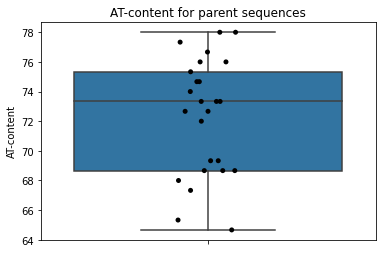

In [284]:
from Bio.SeqUtils import GC
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

AT_contents = []
for ID in parent_seq_ids:
    gc_content = GC(parents_dict[ID])
    
    AT_contents.append(100-gc_content)
    
#print(AT_contents)

sns.boxplot(y=AT_contents)
sns.stripplot(y=AT_contents, color='black', jitter=True)
plt.ylabel('AT-content')
plt.title('AT-content for parent sequences')
#plt.ylim(0,100)

#print(np.mean(AT_contents))
plt.savefig('FigS1_C.pdf')

# Fig S2) Sort-Seq

## A) Barplot with the number of daughter sequences per parent

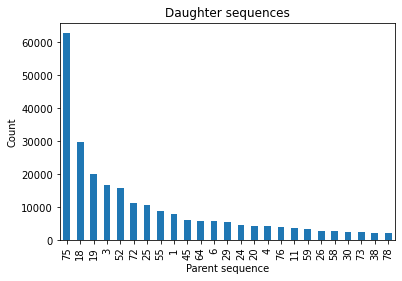

In [264]:
# Use value_counts to count the occurrences of each label
label_counts = df['matched_pi'].value_counts()

# Create a bar plot
label_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Parent sequence')
plt.ylabel('Count')
plt.title('Daughter sequences')

# Save if you want
plt.savefig('FigS2_A.pdf')

## B) Histogram with the number of point mutations per daughter sequence

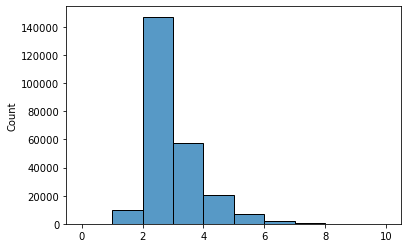

In [265]:
# The number of mutations each duaghter sequence has as a list
muts = df['distance'].to_list()

# The plot function
sns.histplot(muts, binwidth=1)

plt.savefig('Fig_S2_B.pdf')

## C-D) Fluorescence gating

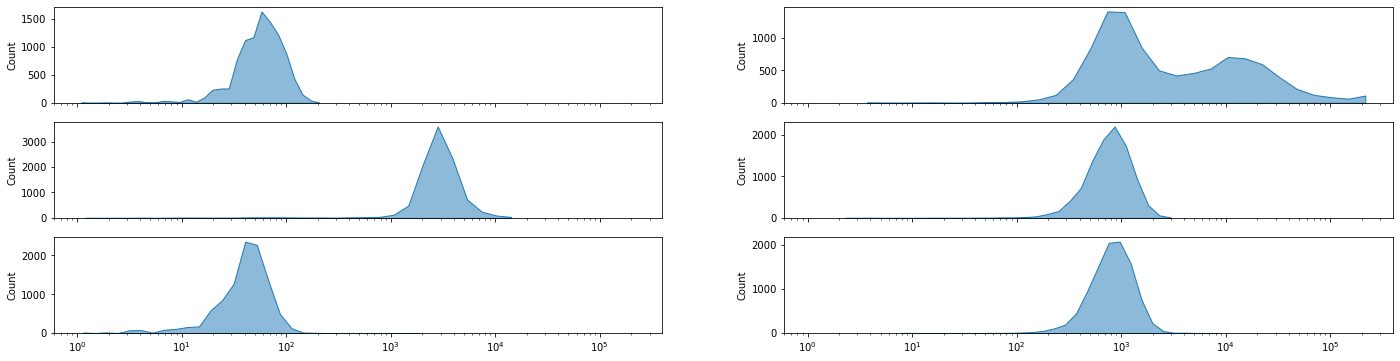

In [266]:
import FlowCal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Open the GFP+ sample (this is the sample name)
gfp = FlowCal.io.FCSData('GFP.fcs')

GFP_sample_GFP = gfp[:, ['FITC-H']]
GFP_sample_GFP = GFP_sample_GFP +1 # Otherwise the log scaling doesn't work...

GFP_sample_RFP = gfp[:, ['PE-H']]
GFP_sample_RFP = GFP_sample_RFP +1 # Otherwise the log scaling doesn't work...


# Open the RFP+ sample (this is the sample name)
rfp = FlowCal.io.FCSData('RFP.fcs')
RFP_sample_RFP = rfp[:, ['PE-H']]
RFP_sample_RFP = RFP_sample_RFP +1

RFP_sample_GFP = rfp[:, ['FITC-H']]
RFP_sample_GFP = RFP_sample_GFP +1


# Open the negative control sample
neg = FlowCal.io.FCSData('empty.fcs')

neg_sample_GFP = neg[:, ['FITC-H']]
neg_sample_GFP = neg_sample_GFP +1

neg_sample_RFP = neg[:, ['PE-H']]
neg_sample_RFP = neg_sample_RFP +1

# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24,6), sharex=True)

### The left subplot is RFP (PE-H)

# The GFP positive control
sns.histplot(GFP_sample_RFP, bins=30, element='poly', log_scale=True, ax=axes[0,0], legend=False, alpha=0.5)

# The RFP positive control
sns.histplot(RFP_sample_RFP, bins=30, element='poly', log_scale=True, ax=axes[1,0], legend=False, alpha=0.5)

# The negative control
sns.histplot(neg_sample_RFP, bins=30, element='poly', log_scale=True, ax=axes[2,0], legend=False, alpha=0.5)

### The right subplot is GFP (FITC-H)
# The GFP positive control
sns.histplot(GFP_sample_GFP, bins=30, element='poly', log_scale=True, ax=axes[0,1], legend=False, alpha=0.5)

# The RFP positive control
sns.histplot(RFP_sample_GFP, bins=30, element='poly', log_scale=True, ax=axes[1,1], legend=False, alpha=0.5)

# The negative control
sns.histplot(neg_sample_GFP, bins=30, element='poly', log_scale=True, ax=axes[2,1], legend=False, alpha=0.5)

# Save
plt.savefig('FigS2_CD.pdf')

# Fig S3) Histograms of the fluorescence score distributions for each parent and fluor

## GFP (top strand)

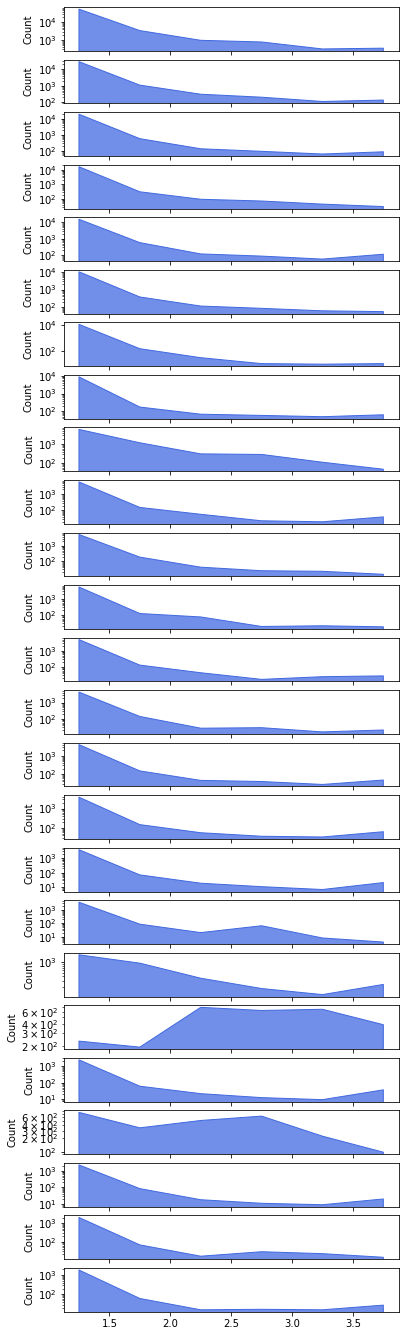

In [272]:
# Set up the subplots
fig, axes = plt.subplots(nrows=len(parent_seq_ids), ncols=1, figsize=(6,24), sharex=True)

for i, parent in enumerate(parent_seq_ids):
    
    sub_df = df[df['matched_pi'].apply(lambda x: x == parent)]
    scores = sub_df['GFP_mean'].to_list()
    #scores = [np.round(n) for n in scores]
    
    # Distplot for data1
    sns.histplot(x=scores, kde=False, ax=axes[i], binwidth=0.50, color='royalblue', element='poly')
    # Set y-axis to log scale
    axes[i].set_yscale('log')

plt.savefig('S3_topstrand.pdf')

## RFP (bottom strand)

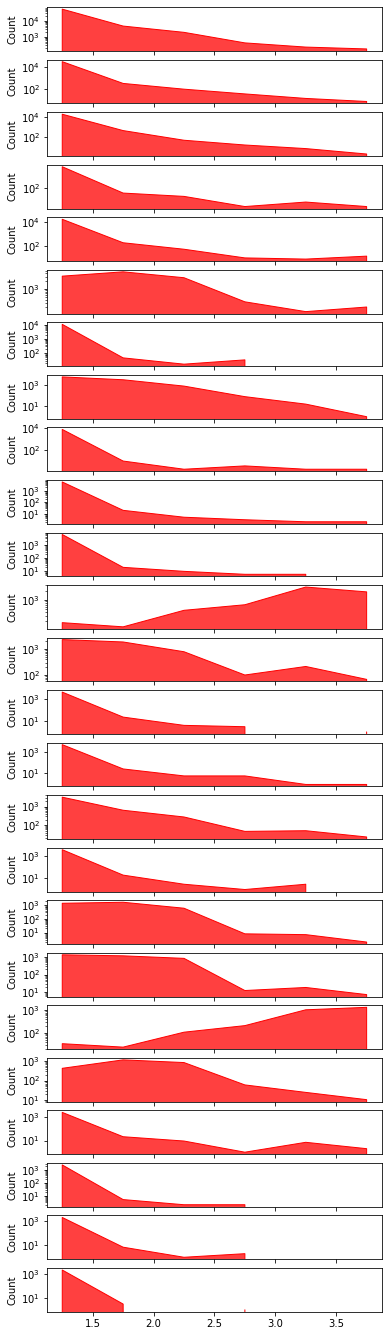

In [273]:
# Set up the subplots
fig, axes = plt.subplots(nrows=len(parent_seq_ids), ncols=1, figsize=(6,24), sharex=True)

for i, parent in enumerate(parent_seq_ids):
    
    sub_df = df[df['matched_pi'].apply(lambda x: x == parent)]
    scores = sub_df['RFP_mean'].to_list()
    #scores = [np.round(n) for n in scores]
    
    # Distplot for data1
    sns.histplot(x=scores, kde=False, ax=axes[i], binwidth=0.50, color='red', element='poly')
    # Set y-axis to log scale
    axes[i].set_yscale('log')

plt.savefig('S3_bottomstrand.pdf')

# Fig S4) Mutual information and PWM plots for all parent sequences
This function returns a figure for each parent. If you want to calculate the mutual information for a single example, run the cells under 'Fig 2)'

In [ ]:
fluors = ['GFP','RFP']
blur = 1

for ID in parent_seq_ids:
    print(ID)
    
    for Fluor in fluors:
        print(Fluor)
        
        # Determine whether the lineplot is red or blue
        if Fluor == 'RFP':
            farbe = 'red'
        elif Fluor == 'GFP':
            farbe = 'blue'

        # ID = parent sequence, orientation = top or bottom, fluor = GFP or RFP, blur = sigma parameter 
        means, std_devs = calculate_mutual_information(ID, Fluor, blur)
               
        # Plot individual...
        x_values = range(len(means))

        # Create a 2-row, 1-column subplot and select the top box
        fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)  # Adjust the figure size as needed
        top_ax = axes[0]

        # Customize x-axis ticks and annotations (every 10 units)
        top_ax.set_xticks(range(0, len(x_values), 10))  # Set ticks every 10 units
        top_ax.set_xticklabels(range(0, len(x_values), 10))  # Set tick labels every 10 units

        # Create the Seaborn line plot for means in the top subplot
        sns.lineplot(x=x_values, y=means, ax=top_ax, color=farbe)

        # Shade the region between mean - 1 std_dev and mean + 1 std_dev using Matplotlib
        top_ax.fill_between(x_values, [mean - std_dev for mean, std_dev in zip(means, std_devs)], 
                         [mean + std_dev for mean, std_dev in zip(means, std_devs)], alpha=0.3, color=farbe)

        top_ax.set_title(f'Mut. info. & PWMs for PI# {ID} - {Fluor}')

        # The y-limit
        top_ax.set_ylim([0, 1.5*np.max(means)])

        # Plot the -10 and -35 boxes
        bot_ax = axes[1]
        WT_pwms(Fluor,window_size,ID)

        # Adjust subplot layout
        plt.tight_layout()

        # Save
        plt.savefig(f'mut_info_pwms_{ID}-{Fluor}.pdf')

# Fig S6: Promoter emergence gain -10/-35 additional examples

### -10 boxes

Unnamed: 0                 1039
Orientation                 top
Parent                        1
Fluor                       GFP
PWM                     minus10
Window_size                   6
P-value                     0.0
ROI                     [9, 15]
N_without                  7541
N_with                      422
Fluor_without          1.138554
Fluor_with             2.891498
Q-value                     0.0
status                     True
gain-loss                  gain
fluorescence_change    1.752943
Hotspot_ID                   31
Name: 91, dtype: object
2.825317654583983e-173

-1.7529434940547017
Unnamed: 0                   1075
Orientation                   top
Parent                          1
Fluor                         GFP
PWM                       minus10
Window_size                     6
P-value                  0.000087
ROI                    [136, 142]
N_without                    7950
N_with                         13
Fluor_without            1.151515
Fluor_with    

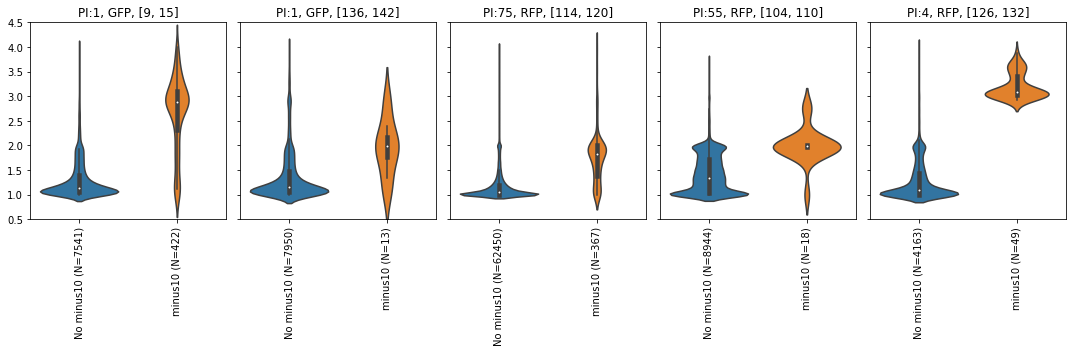

In [287]:
import ast
active_GFP = [30, 59, 26]
active_RFP = [72, 6, 29, 11, 58]

fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
count = 0

for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Do not look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:
        #print(f'{ID}: {Fluor}')
        pass
    
    else:
        # only look at the same strand
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if PWM == 'minus10' and change >= 0.5:

                window = out_row['ROI']
                window = ast.literal_eval(window)
                q_val = out_row['Q-value']
                TF = PWM
                orientation = Orientation
                
                print(out_row)
                print(q_val)
                print()
                
                 # Drop all sequences not in the parent seq
                sub_df = df.drop(df[(df.matched_pi != ID)].index)

                # Drop rows with 'nan' values
                sub_df = sub_df.dropna()

                # Update the window_size if it needs to be different from 6
                if TF == 'minus10' or TF == 'minus35':
                    pass
                else:
                    window_size = len(pwm_dict[TF].consensus)

                # Get the fluorescence scores
                if Fluor == 'GFP':
                    fluorescence_scores = sub_df['GFP_mean'].to_list()
                elif Fluor == 'RFP':
                    fluorescence_scores = sub_df['RFP_mean'].to_list()

                # Get the seqeunces
                sequences = sub_df['seq'].to_list()
                #print(sequences[0])

                # Take the reverse complement if orientation == 'bottom':
                if orientation == 'bottom':
                    sequences = [Seq(sequence).reverse_complement() for sequence in sequences]


                TF_scores = []
                # Loop through each sequence
                for sequence in sequences:

                    # Look exclusively in the provided window
                    crop_sequence = sequence[window[0]:window[1]]

                    # Calculate the PWM score
                    initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                    for position, score in PSSMs_dict[TF].search(crop_sequence):

                        # Only looking on the top strand
                        if position>=0:
                            initial_score = score

                    # Append to a list
                    TF_scores.append(initial_score)

                ### Violin plots between PWM scores below vs above the threshold and fluorescence
                below_fluorescences = []
                above_fluorescences = []

                for n in range(len(TF_scores)):
                    if TF_scores[n] < threshold_dict[TF]:
                        below_fluorescences.append(fluorescence_scores[n])
                    else:
                        above_fluorescences.append(fluorescence_scores[n])

                # Calculate the KS test
                if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:

                    # See if there is a noticable difference between them first
                    median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                    print(median_differences)


                     # Plot the result...
                    all_data = [below_fluorescences, above_fluorescences]

                    # Create a boxplot
                    sns.violinplot(data = all_data, ax=axes[count])
                    #sns.stripplot(data = all_data, palette='dark:black' , jitter=True, alpha=0.5)

                    # Set the y-axis range
                    plt.ylim(0.5, 4.5)

                    # Add labels to the x-axis for each boxplot
                    #axes[count].xticks([0, 1], [f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'])
                    axes[count].set_xticklabels([f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'], rotation=90)
                    axes[count].set_title(f'PI:{ID}, {Fluor}, {window}')
                
                
                    count +=1
                    
plt.tight_layout()
plt.savefig('FigS6_10_violins.pdf')

### -35 boxes

Unnamed: 0                   2757
Orientation                bottom
Parent                         75
Fluor                         RFP
PWM                       minus35
Window_size                     6
P-value                       0.0
ROI                    [107, 113]
N_without                   62689
N_with                        128
Fluor_without            1.055556
Fluor_with                    1.8
Q-value                       0.0
status                       True
gain-loss                    gain
fluorescence_change      0.744444
Hotspot_ID                      6
Name: 173, dtype: object
4.2503669633628745e-42

-0.7444444444444445
Unnamed: 0                 2992
Orientation              bottom
Parent                       19
Fluor                       RFP
PWM                     minus35
Window_size                   6
P-value                     0.0
ROI                    [67, 73]
N_without                 19915
N_with                       67
Fluor_without               1.0
F

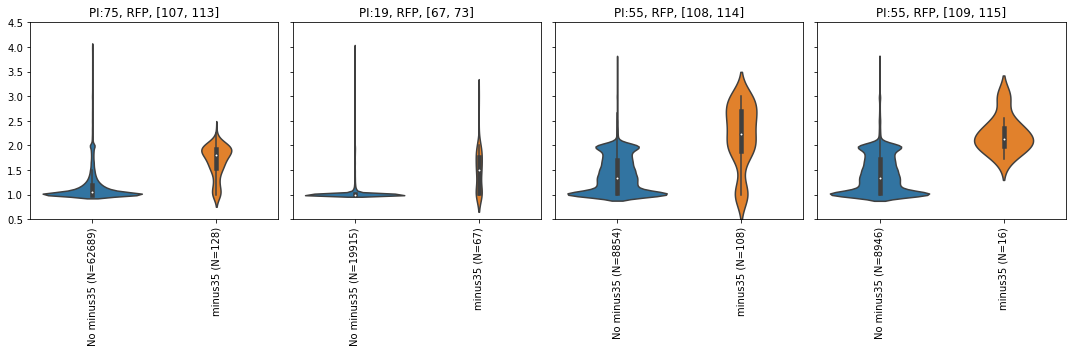

In [290]:
import ast
active_GFP = [30, 59, 26]
active_RFP = [72, 6, 29, 11, 58]

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
count = 0

for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Do not look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:
        #print(f'{ID}: {Fluor}')
        pass
    
    else:
        # only look at the same strand
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if PWM == 'minus35' and change >= 0.5:

                window = out_row['ROI']
                window = ast.literal_eval(window)
                q_val = out_row['Q-value']
                TF = PWM
                orientation = Orientation
                
                print(out_row)
                print(q_val)
                print()
                
                
                # Drop all sequences not in the parent seq
                sub_df = df.drop(df[(df.matched_pi != ID)].index)

                # Drop rows with 'nan' values
                sub_df = sub_df.dropna()

                # Update the window_size if it needs to be different from 6
                if TF == 'minus10' or TF == 'minus35':
                    pass
                else:
                    window_size = len(pwm_dict[TF].consensus)

                # Get the fluorescence scores
                if Fluor == 'GFP':
                    fluorescence_scores = sub_df['GFP_mean'].to_list()
                elif Fluor == 'RFP':
                    fluorescence_scores = sub_df['RFP_mean'].to_list()

                # Get the seqeunces
                sequences = sub_df['seq'].to_list()
                #print(sequences[0])

                # Take the reverse complement if orientation == 'bottom':
                if orientation == 'bottom':
                    sequences = [Seq(sequence).reverse_complement() for sequence in sequences]


                TF_scores = []
                # Loop through each sequence
                for sequence in sequences:

                    # Look exclusively in the provided window
                    crop_sequence = sequence[window[0]:window[1]]

                    # Calculate the PWM score
                    initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                    for position, score in PSSMs_dict[TF].search(crop_sequence):

                        # Only looking on the top strand
                        if position>=0:
                            initial_score = score

                    # Append to a list
                    TF_scores.append(initial_score)

                ### Violin plots between PWM scores below vs above the threshold and fluorescence
                below_fluorescences = []
                above_fluorescences = []

                for n in range(len(TF_scores)):
                    if TF_scores[n] < threshold_dict[TF]:
                        below_fluorescences.append(fluorescence_scores[n])
                    else:
                        above_fluorescences.append(fluorescence_scores[n])

                # Calculate the KS test
                if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:

                    # See if there is a noticable difference between them first
                    median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                    print(median_differences)


                     # Plot the result...
                    all_data = [below_fluorescences, above_fluorescences]

                    # Create a boxplot
                    sns.violinplot(data = all_data, ax=axes[count])
                    #sns.stripplot(data = all_data, palette='dark:black' , jitter=True, alpha=0.5)

                    # Set the y-axis range
                    plt.ylim(0.5, 4.5)

                    # Add labels to the x-axis for each boxplot
                    #axes[count].xticks([0, 1], [f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'])
                    axes[count].set_xticklabels([f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'], rotation=90)
                    axes[count].set_title(f'PI:{ID}, {Fluor}, {window}')
                
                
                    count +=1
                    
plt.tight_layout()
plt.savefig('FigS6_35_violins.pdf')

# Fig S7) Pairwise distances between -10, -35, and 6-mer DNA

In [296]:
# Generate all possible NNNNNN combinations
sixmers = degenerate_combinations("NNNNNN")
print(len(sixmers))

# Generate all possible -10 and -35 boxes
possible_10s = []
possible_35s = []

# For every TF...
list_of_TFs = ['minus10', 'minus35']
for TF in list_of_TFs:
    print(TF)

    # For every possible 6-mer DNA sequence
    for nmer in sixmers:

        # Calculate the PWM score
        initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
        for position, score in PSSMs_dict[TF].search(nmer):

            # Only looking on the top strand
            if position>=0:
                
                # threshold_dict - makes sure the PWM score is greater than the Patser threshold
                if score >= threshold_dict[TF]:
                    initial_score = score
                    #print(window)
                    
            # If the value is greater than 0...add to list 
            if initial_score > 0 and TF == 'minus10':
                possible_10s.append(nmer)
                
            # If the value is greater than 0...add to list
            elif initial_score > 0 and TF == 'minus35':
                possible_35s.append(nmer)

print(len(possible_10s))
print(len(possible_35s))

4096
minus10
minus35
39
72


In [297]:
import numpy as np

ten_thirtyfive_hds = []

for ten in possible_10s:
    for thirtyfive in possible_35s:
        distance = hamming_distance(ten, thirtyfive)
        ten_thirtyfive_hds.append(distance)

print(len(ten_thirtyfive_hds))
print(np.mean(ten_thirtyfive_hds))

sixmer_ten_hds = []

for ten in possible_10s:
    for sixmer in sixmers:
        distance = hamming_distance(ten, sixmer)
        sixmer_ten_hds.append(distance)
        
print(len(sixmer_ten_hds))
print(np.mean(sixmer_ten_hds))

sixmer_thirtyfive_hds = []

for thirtyfive in possible_35s:
    for sixmer in sixmers:
        distance = hamming_distance(thirtyfive, sixmer)
        sixmer_thirtyfive_hds.append(distance)
        
print(len(sixmer_thirtyfive_hds))
print(np.mean(sixmer_thirtyfive_hds))

2808
4.005698005698005
159744
4.5
294912
4.5


In [298]:
import scipy.stats as stats
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example data
group1 = ten_thirtyfive_hds
group2 = sixmer_ten_hds
group3 = sixmer_thirtyfive_hds

# Perform One-Way ANOVA
statistic, p_value = stats.f_oneway(group1, group2, group3)

# Print the results
print(f'One-Way ANOVA F-statistic: {statistic}')
print(f'One-Way ANOVA p-value: {p_value}')

# Check for statistical significance
if p_value < 0.05:
    print('There is a significant difference among the groups.')

    # Create a DataFrame for Tukey's HSD
    df_tukey = pd.DataFrame({'Values': group1 + group2 + group3,
                             'Group': ['Group1'] * len(group1) + ['Group2'] * len(group2) + ['Group3'] * len(group3)})

    # Tukey's HSD post hoc test
    tukey_result = pairwise_tukeyhsd(df_tukey['Values'], df_tukey['Group'])

    # Print the Tukey's HSD results
    print(tukey_result)
else:
    print('No significant difference among the groups.')

One-Way ANOVA F-statistic: 303.4301493024659
One-Way ANOVA p-value: 2.0384055264220835e-132
There is a significant difference among the groups.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
Group1 Group2   0.4943  -0.0   0.447 0.5416   True
Group1 Group3   0.4943  -0.0  0.4472 0.5414   True
Group2 Group3      0.0   1.0 -0.0077 0.0077  False
--------------------------------------------------


4.005698005698005
4.5
4.5
4.0
5.0
5.0


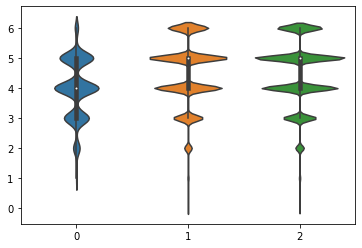

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt

print(np.mean(group1))
print(np.mean(group2))
print(np.mean(group3))

print(np.median(group1))
print(np.median(group2))
print(np.median(group3))

# Plot the result...
all_data = [group1, group2, group3]

# Create a boxplot
sns.violinplot(data = all_data)
plt.savefig('FigS7_A.pdf')

# Fig S8) Gaining motifs increases fluorescence

Unnamed: 0                  2137
Orientation                  top
Parent                        59
Fluor                        GFP
PWM                      minus10
Window_size                    6
P-value                  0.00028
ROI                    [99, 105]
N_without                   3445
N_with                        11
Fluor_without           1.558442
Fluor_with               2.50885
Q-value                 0.002028
status                      True
gain-loss                   gain
fluorescence_change     0.950408
Hotspot_ID                    51
Name: 133, dtype: object
0.0020280645237706

-0.9504079990805658
Unnamed: 0                 2221
Orientation                 top
Parent                       26
Fluor                       GFP
PWM                     minus10
Window_size                   6
P-value                0.000001
ROI                    [46, 52]
N_without                  2699
N_with                       86
Fluor_without          2.666667
Fluor_with            

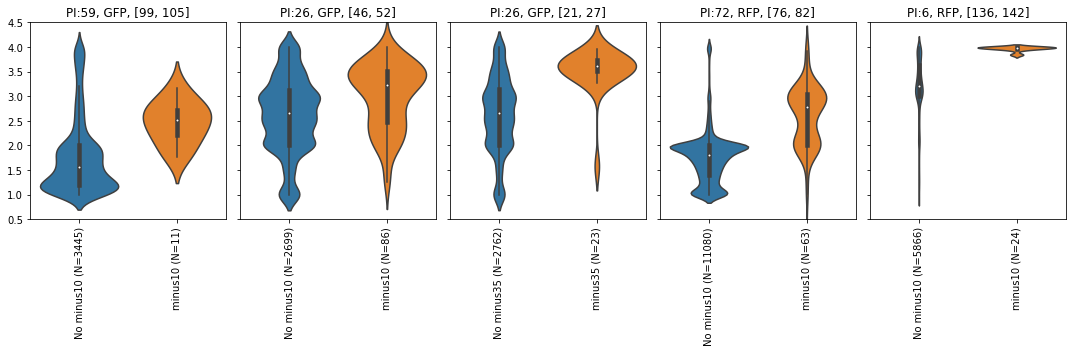

In [304]:
import ast
active_GFP = [30, 59, 26]
active_RFP = [72, 6, 29, 11, 58]

fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
count = 0
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Only look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:

        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if change >= 0.5 and gain_loss == 'gain':

                # PLOT
                window = out_row['ROI']
                window = ast.literal_eval(window)
                q_val = out_row['Q-value']
                TF = PWM
                orientation = Orientation
                
                print(out_row)
                print(q_val)
                print()
                
                 # Drop all sequences not in the parent seq
                sub_df = df.drop(df[(df.matched_pi != ID)].index)

                # Drop rows with 'nan' values
                sub_df = sub_df.dropna()

                # Update the window_size if it needs to be different from 6
                if TF == 'minus10' or TF == 'minus35':
                    pass
                else:
                    window_size = len(pwm_dict[TF].consensus)

                # Get the fluorescence scores
                if Fluor == 'GFP':
                    fluorescence_scores = sub_df['GFP_mean'].to_list()
                elif Fluor == 'RFP':
                    fluorescence_scores = sub_df['RFP_mean'].to_list()

                # Get the seqeunces
                sequences = sub_df['seq'].to_list()
                #print(sequences[0])

                # Take the reverse complement if orientation == 'bottom':
                if orientation == 'bottom':
                    sequences = [Seq(sequence).reverse_complement() for sequence in sequences]


                TF_scores = []
                # Loop through each sequence
                for sequence in sequences:

                    # Look exclusively in the provided window
                    crop_sequence = sequence[window[0]:window[1]]

                    # Calculate the PWM score
                    initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                    for position, score in PSSMs_dict[TF].search(crop_sequence):

                        # Only looking on the top strand
                        if position>=0:
                            initial_score = score

                    # Append to a list
                    TF_scores.append(initial_score)

                ### Violin plots between PWM scores below vs above the threshold and fluorescence
                below_fluorescences = []
                above_fluorescences = []

                for n in range(len(TF_scores)):
                    if TF_scores[n] < threshold_dict[TF]:
                        below_fluorescences.append(fluorescence_scores[n])
                    else:
                        above_fluorescences.append(fluorescence_scores[n])

                # Calculate the KS test
                if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:

                    # See if there is a noticable difference between them first
                    median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                    print(median_differences)


                     # Plot the result...
                    all_data = [below_fluorescences, above_fluorescences]

                    # Create a boxplot
                    sns.violinplot(data = all_data, ax=axes[count])
                    #sns.stripplot(data = all_data, palette='dark:black' , jitter=True, alpha=0.5)

                    # Set the y-axis range
                    plt.ylim(0.5, 4.5)

                    # Add labels to the x-axis for each boxplot
                    #axes[count].xticks([0, 1], [f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'])
                    axes[count].set_xticklabels([f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'], rotation=90)
                    axes[count].set_title(f'PI:{ID}, {Fluor}, {window}')
                
                
                    count +=1
                    
plt.tight_layout()
plt.savefig('FigS8_violins.pdf')

# Fig S9) Destroying motifs decreases expression in active promoters

### -10 boxes first

Unnamed: 0                 3375
Orientation              bottom
Parent                       72
Fluor                       RFP
PWM                     minus10
Window_size                   6
P-value                     0.0
ROI                    [92, 98]
N_without                   930
N_with                    10213
Fluor_without          1.263768
Fluor_with             1.833333
Q-value                     0.0
status                     True
gain-loss                  loss
fluorescence_change   -0.569565
Hotspot_ID                   27
Name: 224, dtype: object
8.699218866967126e-26

-0.5695652173913042
Unnamed: 0                  3376
Orientation               bottom
Parent                        72
Fluor                        RFP
PWM                      minus10
Window_size                    6
P-value                      0.0
ROI                    [94, 100]
N_without                    934
N_with                     10209
Fluor_without                1.1
Fluor_with              1

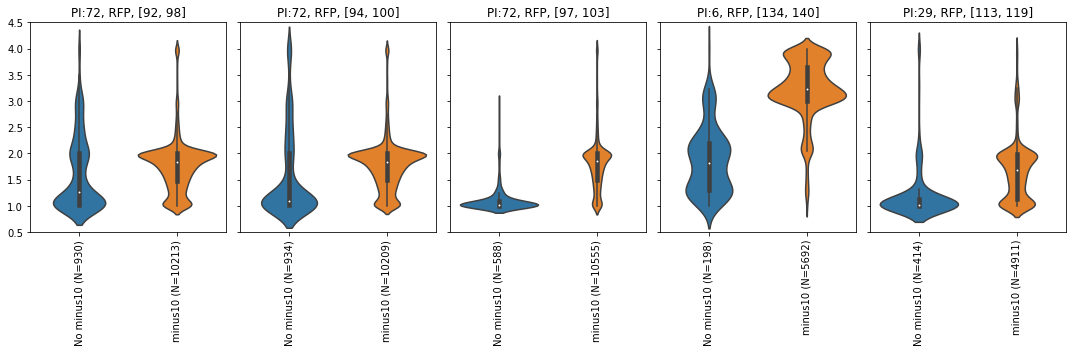

In [306]:
import ast
active_GFP = [30, 59, 26]
active_RFP = [72, 6, 29, 11, 58]

fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
count = 0
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Only look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:

        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if change <= -0.5 and gain_loss == 'loss' and PWM == 'minus10':

                # PLOT
                window = out_row['ROI']
                window = ast.literal_eval(window)
                q_val = out_row['Q-value']
                TF = PWM
                orientation = Orientation
                
                print(out_row)
                print(q_val)
                print()
                
                 # Drop all sequences not in the parent seq
                sub_df = df.drop(df[(df.matched_pi != ID)].index)

                # Drop rows with 'nan' values
                sub_df = sub_df.dropna()

                # Update the window_size if it needs to be different from 6
                if TF == 'minus10' or TF == 'minus35':
                    pass
                else:
                    window_size = len(pwm_dict[TF].consensus)

                # Get the fluorescence scores
                if Fluor == 'GFP':
                    fluorescence_scores = sub_df['GFP_mean'].to_list()
                elif Fluor == 'RFP':
                    fluorescence_scores = sub_df['RFP_mean'].to_list()

                # Get the seqeunces
                sequences = sub_df['seq'].to_list()
                #print(sequences[0])

                # Take the reverse complement if orientation == 'bottom':
                if orientation == 'bottom':
                    sequences = [Seq(sequence).reverse_complement() for sequence in sequences]


                TF_scores = []
                # Loop through each sequence
                for sequence in sequences:

                    # Look exclusively in the provided window
                    crop_sequence = sequence[window[0]:window[1]]

                    # Calculate the PWM score
                    initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                    for position, score in PSSMs_dict[TF].search(crop_sequence):

                        # Only looking on the top strand
                        if position>=0:
                            initial_score = score

                    # Append to a list
                    TF_scores.append(initial_score)

                ### Violin plots between PWM scores below vs above the threshold and fluorescence
                below_fluorescences = []
                above_fluorescences = []

                for n in range(len(TF_scores)):
                    if TF_scores[n] < threshold_dict[TF]:
                        below_fluorescences.append(fluorescence_scores[n])
                    else:
                        above_fluorescences.append(fluorescence_scores[n])

                # Calculate the KS test
                if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:

                    # See if there is a noticable difference between them first
                    median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                    print(median_differences)


                     # Plot the result...
                    all_data = [below_fluorescences, above_fluorescences]

                    # Create a boxplot
                    sns.violinplot(data = all_data, ax=axes[count])
                    #sns.stripplot(data = all_data, palette='dark:black' , jitter=True, alpha=0.5)

                    # Set the y-axis range
                    plt.ylim(0.5, 4.5)

                    # Add labels to the x-axis for each boxplot
                    #axes[count].xticks([0, 1], [f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'])
                    axes[count].set_xticklabels([f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'], rotation=90)
                    axes[count].set_title(f'PI:{ID}, {Fluor}, {window}')
                
                
                    count +=1
                    
plt.tight_layout()
plt.savefig('FigS9_10_violins.pdf')

### -35 boxes next

Unnamed: 0                   2381
Orientation                   top
Parent                         30
Fluor                         GFP
PWM                       minus35
Window_size                     6
P-value                       0.0
ROI                    [110, 116]
N_without                     279
N_with                       2283
Fluor_without            1.318182
Fluor_with               2.206897
Q-value                       0.0
status                       True
gain-loss                    loss
fluorescence_change     -0.888715
Hotspot_ID                     65
Name: 149, dtype: object
7.191824804149176e-35

-0.88871473354232
Unnamed: 0                   4069
Orientation                bottom
Parent                          6
Fluor                         RFP
PWM                       minus35
Window_size                     6
P-value                       0.0
ROI                    [110, 116]
N_without                     152
N_with                       5738
Fluor_without   

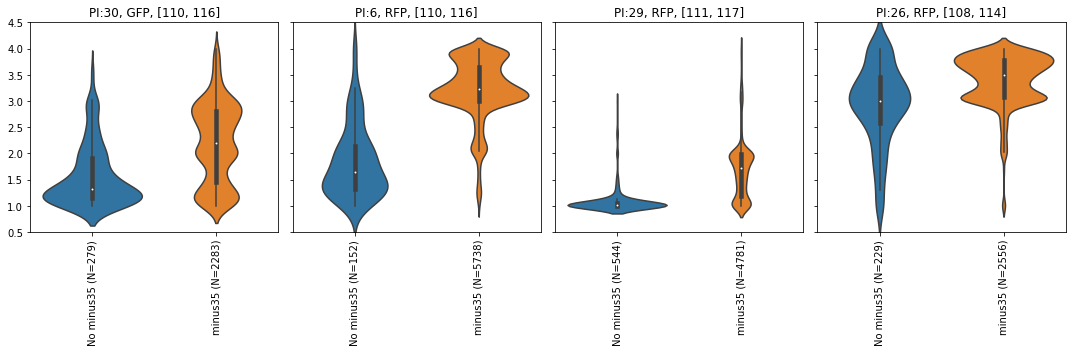

In [308]:
import ast
active_GFP = [30, 59, 26]
active_RFP = [72, 6, 29, 11, 58]

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
count = 0
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Only look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:

        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if change <= -0.5 and gain_loss == 'loss' and PWM == 'minus35':

                # PLOT
                window = out_row['ROI']
                window = ast.literal_eval(window)
                q_val = out_row['Q-value']
                TF = PWM
                orientation = Orientation
                
                print(out_row)
                print(q_val)
                print()
                
                 # Drop all sequences not in the parent seq
                sub_df = df.drop(df[(df.matched_pi != ID)].index)

                # Drop rows with 'nan' values
                sub_df = sub_df.dropna()

                # Update the window_size if it needs to be different from 6
                if TF == 'minus10' or TF == 'minus35':
                    pass
                else:
                    window_size = len(pwm_dict[TF].consensus)

                # Get the fluorescence scores
                if Fluor == 'GFP':
                    fluorescence_scores = sub_df['GFP_mean'].to_list()
                elif Fluor == 'RFP':
                    fluorescence_scores = sub_df['RFP_mean'].to_list()

                # Get the seqeunces
                sequences = sub_df['seq'].to_list()
                #print(sequences[0])

                # Take the reverse complement if orientation == 'bottom':
                if orientation == 'bottom':
                    sequences = [Seq(sequence).reverse_complement() for sequence in sequences]


                TF_scores = []
                # Loop through each sequence
                for sequence in sequences:

                    # Look exclusively in the provided window
                    crop_sequence = sequence[window[0]:window[1]]

                    # Calculate the PWM score
                    initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                    for position, score in PSSMs_dict[TF].search(crop_sequence):

                        # Only looking on the top strand
                        if position>=0:
                            initial_score = score

                    # Append to a list
                    TF_scores.append(initial_score)

                ### Violin plots between PWM scores below vs above the threshold and fluorescence
                below_fluorescences = []
                above_fluorescences = []

                for n in range(len(TF_scores)):
                    if TF_scores[n] < threshold_dict[TF]:
                        below_fluorescences.append(fluorescence_scores[n])
                    else:
                        above_fluorescences.append(fluorescence_scores[n])

                # Calculate the KS test
                if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:

                    # See if there is a noticable difference between them first
                    median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                    print(median_differences)


                     # Plot the result...
                    all_data = [below_fluorescences, above_fluorescences]

                    # Create a boxplot
                    sns.violinplot(data = all_data, ax=axes[count])
                    #sns.stripplot(data = all_data, palette='dark:black' , jitter=True, alpha=0.5)

                    # Set the y-axis range
                    plt.ylim(0.5, 4.5)

                    # Add labels to the x-axis for each boxplot
                    #axes[count].xticks([0, 1], [f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'])
                    axes[count].set_xticklabels([f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'], rotation=90)
                    axes[count].set_title(f'PI:{ID}, {Fluor}, {window}')
                
                
                    count +=1
                    
plt.tight_layout()
plt.savefig('FigS9_35_violins.pdf')

# Fig S10) Creating -10 and -35 boxes LOWERS expression

Unnamed: 0                  2239
Orientation                  top
Parent                        26
Fluor                        GFP
PWM                      minus35
Window_size                    6
P-value                 0.008845
ROI                    [95, 101]
N_without                   2766
N_with                        19
Fluor_without           2.666667
Fluor_with                   2.0
Q-value                 0.037095
status                      True
gain-loss                   gain
fluorescence_change    -0.666667
Hotspot_ID                    58
Name: 141, dtype: object
0.0370947154105149

0.6666666666666665
Unnamed: 0                   2355
Orientation                   top
Parent                         30
Fluor                         GFP
PWM                       minus10
Window_size                     6
P-value                       0.0
ROI                    [111, 117]
N_without                    2537
N_with                         25
Fluor_without            2.083333
F

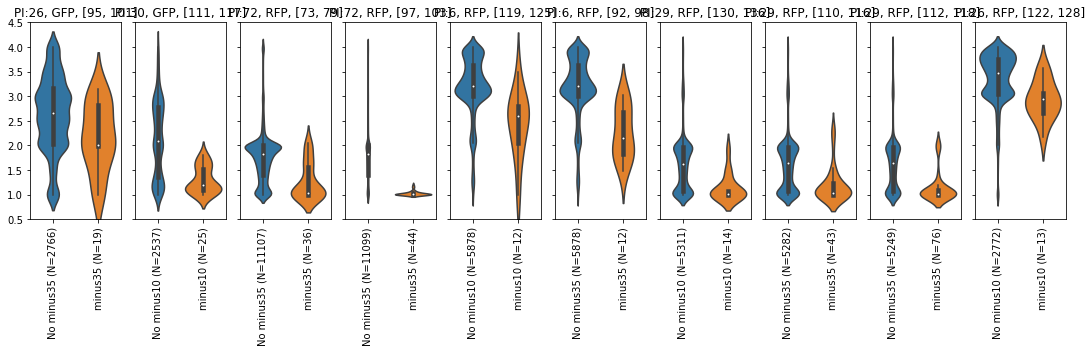

In [310]:
import ast
active_GFP = [30, 59, 26]
active_RFP = [72, 6, 29, 11, 58]

fig, axes = plt.subplots(1, 10, figsize=(15, 5), sharey=True)
count = 0
for i, out_row in output_df.iterrows():
    
    ID = out_row['Parent']
    Fluor = out_row['Fluor']
    Orientation = out_row['Orientation']
    gain_loss = out_row['gain-loss']
    PWM = out_row['PWM']
    change = out_row['fluorescence_change']
    
    # Only look at already active sequences
    if Fluor == 'GFP' and ID in GFP_active or Fluor == 'RFP' and ID in RFP_active:

        # Only look at gains on the same side
        if Fluor == 'GFP' and Orientation == 'top' or Fluor == 'RFP' and Orientation == 'bottom':
            
            if change <= -0.5 and gain_loss == 'gain':

                # PLOT
                window = out_row['ROI']
                window = ast.literal_eval(window)
                q_val = out_row['Q-value']
                TF = PWM
                orientation = Orientation
                
                print(out_row)
                print(q_val)
                print()
                
                 # Drop all sequences not in the parent seq
                sub_df = df.drop(df[(df.matched_pi != ID)].index)

                # Drop rows with 'nan' values
                sub_df = sub_df.dropna()

                # Update the window_size if it needs to be different from 6
                if TF == 'minus10' or TF == 'minus35':
                    pass
                else:
                    window_size = len(pwm_dict[TF].consensus)

                # Get the fluorescence scores
                if Fluor == 'GFP':
                    fluorescence_scores = sub_df['GFP_mean'].to_list()
                elif Fluor == 'RFP':
                    fluorescence_scores = sub_df['RFP_mean'].to_list()

                # Get the seqeunces
                sequences = sub_df['seq'].to_list()
                #print(sequences[0])

                # Take the reverse complement if orientation == 'bottom':
                if orientation == 'bottom':
                    sequences = [Seq(sequence).reverse_complement() for sequence in sequences]


                TF_scores = []
                # Loop through each sequence
                for sequence in sequences:

                    # Look exclusively in the provided window
                    crop_sequence = sequence[window[0]:window[1]]

                    # Calculate the PWM score
                    initial_score = 0 # You have to have a variable that updates outside of this, since it sometimes doesn't find a variable and won't return a score for each sequence...
                    for position, score in PSSMs_dict[TF].search(crop_sequence):

                        # Only looking on the top strand
                        if position>=0:
                            initial_score = score

                    # Append to a list
                    TF_scores.append(initial_score)

                ### Violin plots between PWM scores below vs above the threshold and fluorescence
                below_fluorescences = []
                above_fluorescences = []

                for n in range(len(TF_scores)):
                    if TF_scores[n] < threshold_dict[TF]:
                        below_fluorescences.append(fluorescence_scores[n])
                    else:
                        above_fluorescences.append(fluorescence_scores[n])

                # Calculate the KS test
                if len(below_fluorescences) > 9 and len(above_fluorescences) > 9:

                    # See if there is a noticable difference between them first
                    median_differences = np.median(below_fluorescences) - np.median(above_fluorescences)
                    print(median_differences)


                     # Plot the result...
                    all_data = [below_fluorescences, above_fluorescences]

                    # Create a boxplot
                    sns.violinplot(data = all_data, ax=axes[count])
                    #sns.stripplot(data = all_data, palette='dark:black' , jitter=True, alpha=0.5)

                    # Set the y-axis range
                    plt.ylim(0.5, 4.5)

                    # Add labels to the x-axis for each boxplot
                    #axes[count].xticks([0, 1], [f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'])
                    axes[count].set_xticklabels([f'No {TF} (N={len(below_fluorescences)})', f'{TF} (N={len(above_fluorescences)})'], rotation=90)
                    axes[count].set_title(f'PI:{ID}, {Fluor}, {window}')
                
                
                    count +=1
                    
plt.tight_layout()
plt.savefig('FigS10_violins.pdf')